# Lab 4
Let's go back to using the Lab1 data and see if we are now able to improve on what linear regression was not able to do.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={"figure.figsize": (10, 6)})
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.style.use('ggplot') # setting the plot style
%matplotlib inline
from __future__ import print_function, unicode_literals, division

# ignore various warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import drive

# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# planetData = pd.read_csv("/content/drive/MyDrive/DataIntesive/Data/oec.csv")

planetData = pd.read_csv("oec.csv")

In [4]:
planetData.columns

Index(['PlanetIdentifier', 'TypeFlag', 'PlanetaryMassJpt', 'RadiusJpt',
       'PeriodDays', 'SemiMajorAxisAU', 'Eccentricity', 'PeriastronDeg',
       'LongitudeDeg', 'AscendingNodeDeg', 'InclinationDeg', 'SurfaceTempK',
       'AgeGyr', 'DiscoveryMethod', 'DiscoveryYear', 'LastUpdated',
       'RightAscension', 'Declination', 'DistFromSunParsec',
       'HostStarMassSlrMass', 'HostStarRadiusSlrRad', 'HostStarMetallicity',
       'HostStarTempK', 'HostStarAgeGyr'],
      dtype='object')

In [5]:
planetData['PeriodYears'] = planetData['PeriodDays']/365.25
mult_cols = ['SemiMajorAxisAU','HostStarMassSlrMass',
             'PlanetaryMassJpt','PeriodYears']   # take X to be 6 columns and y to be 1 column
mult_features = ['SemiMajorAxisAU','HostStarMassSlrMass', 'PlanetaryMassJpt']
planets_selectedFeatures = planetData[mult_cols].dropna()

X_mult = planets_selectedFeatures[mult_features]
y_mult = planets_selectedFeatures['PeriodYears']   # y is the PeriodYears column
print("Number of observations: ", X_mult.shape[0])
print("Number of values for the response variable y: ", y_mult.shape[0])

Number of observations:  980
Number of values for the response variable y:  980


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mult, y_mult, test_size=0.3, random_state=42)
# Split arrays or matrices into random train and test subsets
# -- use random state for debugging purposes
print("training data size:",X_train.shape)
print("testing data size:",X_test.shape)
print ("total data size:", X_mult.shape)
print("size of y_mult:", y_mult.shape)
print("size of y_mult_train: ", y_train.shape)
print("size of y_mult_test: ", y_test.shape)

training data size: (686, 3)
testing data size: (294, 3)
total data size: (980, 3)
size of y_mult: (980,)
size of y_mult_train:  (686,)
size of y_mult_test:  (294,)


In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Based on the previous examples, test a neural network to predict y_test and calculate r2.

*  Try different configurations of layers and neurons and get a good result.
*  With your final neural network configuration. Experiment with different learning rates (0.1, 0.01, 0.001) and batch sizes (8, 16, 32, 64). How do these hyperparameters affect the training process, loss, and final model accuracy? Run experiments by varying the learning rate and batch size, then compare the results in terms of convergence, accuracy, and training speed.

STEP 1: Import the necessary libraries

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

# Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

STEP 2: Define the Neural Network Class

We'll define a simple feedforward neural network with fully connected layers (linear layers). You can experiment with the number of layers and neurons.

In [9]:
# Define a neural network class with a flexible architecture
class AstroNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(AstroNet, self).__init__()

        network_layers = []
        # Dynamically build the hidden layers
        for layer_idx in range(len(hidden_layers)):
            if layer_idx == 0:
                network_layers.append(nn.Linear(input_dim, hidden_layers[layer_idx]))  # Connect input to first hidden layer
            else:
                network_layers.append(nn.Linear(hidden_layers[layer_idx-1], hidden_layers[layer_idx]))  # Connect hidden layers

            network_layers.append(nn.ReLU())  # ReLU activation after each hidden layer

        network_layers.append(nn.Linear(hidden_layers[-1], output_dim))  # Connect to output layer
        self.net = nn.Sequential(*network_layers)

    def forward(self, x):
        return self.net(x)


STEP 3: Prepare Data as Tensors

Before training, we need to convert our input and output data into PyTorch tensors.

In [10]:
# Convert data into tensors for training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


STEP 4: Train the Model

Define a function to train the neural network. This will handle the forward pass, backpropagation, and loss calculation during training, and will also include evaluation on a validation set.

In [11]:
# Define a function to train the model
def train_network(model, loss_fn, optim_fn, train_data, val_data, n_epochs=100):
    for ep in range(n_epochs):
        model.train()  # Set the model in training mode
        total_train_loss = 0.0
        for features, labels in train_data:
            optim_fn.zero_grad()  # Clear the gradients
            pred = model(features)
            loss = loss_fn(pred, labels)
            loss.backward()  # Perform backpropagation
            optim_fn.step()  # Apply gradient descent
            total_train_loss += loss.item()

        # Evaluate on validation set
        model.eval()  # Set the model in evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():
            for val_features, val_labels in val_data:
                val_predictions = model(val_features)
                total_val_loss += loss_fn(val_predictions, val_labels).item()

        if ep % 10 == 0:
            print(f'Epoch {ep}/{n_epochs}, Training Loss: {total_train_loss / len(train_data)}, Validation Loss: {total_val_loss / len(val_data)}')


STEP 5: Evaluate the Model

A function to calculate the R² score on the test data. This helps determine the model’s performance on unseen data.

In [12]:
# Define a function to evaluate the model's R² score
def assess_model_performance(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        r2 = r2_score(y_test.cpu().numpy(), preds.cpu().numpy())
        print(f'R² Score: {r2:.4f}')
        return r2


STEP 6: Set Hyperparameters and Train the Model

Define different combinations of hyperparameters such as learning rate, batch size, and network architectures. Then loop through each combination and train the model.

In [13]:
# Define hyperparameters for the experiment
lr_list = [0.1, 0.01, 0.001]
batch_size_options = [8, 16, 32, 64]
network_structures = [
    [64],        # 1 hidden layer with 64 units
    [128, 64],   # 2 hidden layers with 128 and 64 units
    [128, 64, 32]  # 3 hidden layers with 128, 64, and 32 units
]

# Loop through configurations of hyperparameters
for structure in network_structures:
    for learning_rate in lr_list:
        for b_size in batch_size_options:
            print(f"\nStarting training with structure {structure}, learning rate {learning_rate}, and batch size {b_size}...\n")

            # Prepare data loaders for training and validation
            train_data_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
                batch_size=b_size, shuffle=True
            )
            val_data_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
                batch_size=b_size, shuffle=False
            )

            # Initialize the network, loss function, and optimizer
            net = AstroNet(input_dim=3, hidden_layers=structure, output_dim=1)
            loss_function = nn.MSELoss()  # Use Mean Squared Error as the loss function
            optimizer_fn = optim.Adam(net.parameters(), lr=learning_rate)

            # Train the model
            train_network(net, loss_function, optimizer_fn, train_data_loader, val_data_loader, n_epochs=100)

            # Evaluate model performance on test set
            assess_model_performance(net, X_test_tensor, y_test_tensor)



Starting training with structure [64], learning rate 0.1, and batch size 8...

Epoch 0/100, Training Loss: 774.5280625362728, Validation Loss: 122.26903787819114
Epoch 10/100, Training Loss: 58.93502385689076, Validation Loss: 2.4160560832635776
Epoch 20/100, Training Loss: 31.1440951176161, Validation Loss: 2.0822851851179793
Epoch 30/100, Training Loss: 54.90820314267347, Validation Loss: 2.5027041600362674
Epoch 40/100, Training Loss: 44.668533701362996, Validation Loss: 0.8818525289361542
Epoch 50/100, Training Loss: 24.59440755766145, Validation Loss: 1.1713652361083675
Epoch 60/100, Training Loss: 23.989832424320454, Validation Loss: 1.6155150041386888
Epoch 70/100, Training Loss: 77.37822748313464, Validation Loss: 2.4614360259996877
Epoch 80/100, Training Loss: 33.5326813958412, Validation Loss: 1.545321860023447
Epoch 90/100, Training Loss: 30.698603050913228, Validation Loss: 1.346727341816232
R² Score: 0.9409

Starting training with structure [64], learning rate 0.1, and ba

STEP 7: Training Function

This function handles the model training process. It also collects training and validation loss to visualize performance and implements backpropagation.

In [14]:
# Function to train the neural network
def train_optimized_model(model, loss_fn, optimizer_fn, train_loader, val_loader, num_epochs=100):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()  # Set to training mode
        total_train_loss = 0.0

        for data_x, data_y in train_loader:
            optimizer_fn.zero_grad()  # Clear gradients
            predictions = model(data_x)
            loss = loss_fn(predictions, data_y)
            loss.backward()  # Backpropagate
            optimizer_fn.step()  # Gradient update

            total_train_loss += loss.item()

        # Validation loop
        model.eval()  # Switch to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_pred = model(val_x)
                total_val_loss += loss_fn(val_pred, val_y).item()

        training_losses.append(total_train_loss / len(train_loader))
        validation_losses.append(total_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {total_train_loss / len(train_loader)}, Validation Loss: {total_val_loss / len(val_loader)}')

    return training_losses, validation_losses


STEP 8: Evaluation Function

This function evaluates the model by calculating predictions on the test set and computing the R² score for performance evaluation.

In [15]:
# Function to evaluate the model's performance using R² score
def evaluate_optimized_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predicted = model(X_test)
        r2_val = r2_score(y_test.cpu().numpy(), predicted.cpu().numpy())
        print(f'R² Score: {r2_val:.4f}')
        return predicted, r2_val


STEP 9: Loss and Performance Plotting

Two functions are added to plot:
  - Training vs. Validation Loss over epochs.
  - True vs. Predicted Values to visualize how well the model performs on the test set.

In [16]:
# Plot training and validation loss
def plot_loss_curves(train_loss, val_loss, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot true vs predicted values
def plot_true_vs_pred(y_true, y_pred, plot_title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # Diagonal reference line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(plot_title)
    plt.grid(True)
    plt.show()


STEP 10: Experimentation Loop and Best Model Identification

We loop through different learning rates and batch sizes, training and evaluating the model. We also track the best model configuration based on the highest R² score, and print out the best parameters at the end.

In [17]:
# Conduct full experiment and track the best model
def run_optimized_experiment(hidden_layers_list, lr_list, batch_sizes, epochs):
    # # Convert data to tensors
    # X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    # X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    # y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    # y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Initialize variables to store the best model information
    best_r2 = -float('inf')
    best_model_params = {
        'hidden_layers': None,
        'learning_rate': None,
        'batch_size': None,
        'r2_score': None
    }

    # Iterate over different architectures, learning rates, and batch sizes
    for hidden_layers in hidden_layers_list:
        for lr in lr_list:
            for b_size in batch_sizes:
                print(f"\nTraining with hidden layers {hidden_layers}, learning rate {lr} and batch size {b_size}...\n")

                # Create data loaders for training and validation
                train_loader = torch.utils.data.DataLoader(
                    dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
                    batch_size=b_size, shuffle=True
                )
                val_loader = torch.utils.data.DataLoader(
                    dataset=torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
                    batch_size=b_size, shuffle=False
                )

                # Initialize the model, loss function, and optimizer
                model = AstroNet(input_dim=3, hidden_layers=hidden_layers, output_dim=1)  # Reuse the existing class
                loss_fn = nn.MSELoss()
                optimizer_fn = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                train_loss, val_loss = train_optimized_model(model, loss_fn, optimizer_fn, train_loader, val_loader, num_epochs=epochs)

                # Evaluate model performance
                preds, r2_val = evaluate_optimized_model(model, X_test_tensor, y_test_tensor)

                # Check if this is the best model
                if r2_val > best_r2:
                    best_r2 = r2_val
                    best_model_params['hidden_layers'] = hidden_layers
                    best_model_params['learning_rate'] = lr
                    best_model_params['batch_size'] = b_size
                    best_model_params['r2_score'] = r2_val

                # Plot results
                plot_loss_curves(train_loss, val_loss, f"Loss Curves: Hidden Layers={hidden_layers}, LR={lr}, Batch Size={b_size}")
                plot_true_vs_pred(y_test_tensor.cpu().numpy(), preds.cpu().numpy(), f"True vs Predicted: Hidden Layers={hidden_layers}, LR={lr}, Batch Size={b_size}")

    # Print the best configuration
    print(f"\nBest Model Configuration:")
    print(f"  Hidden Layers: {best_model_params['hidden_layers']}")
    print(f"  Learning Rate: {best_model_params['learning_rate']}")
    print(f"  Batch Size: {best_model_params['batch_size']}")
    print(f"  Best R² Score: {best_model_params['r2_score']:.4f}")


STEP 11: Hyperparameter Setup and Model Execution

We define the hyperparameters such as hidden layer sizes, learning rates, batch sizes, and the number of epochs. Then we run the experiment.


Training with hidden layers [64], learning rate 0.1 and batch size 8...

Epoch 0/100, Training Loss: 493.98614426442356, Validation Loss: 4.734891488745406
Epoch 10/100, Training Loss: 85.82971620213154, Validation Loss: 5.950448712787113
Epoch 20/100, Training Loss: 31.616459296366504, Validation Loss: 2.808122218057916
Epoch 30/100, Training Loss: 44.10534258351423, Validation Loss: 1.362563613298777
Epoch 40/100, Training Loss: 63.516713472516386, Validation Loss: 1.2694964261876571
Epoch 50/100, Training Loss: 19.459128628636517, Validation Loss: 0.5516832780999106
Epoch 60/100, Training Loss: 22.457937863503776, Validation Loss: 1.114588910462083
Epoch 70/100, Training Loss: 145.28270259196327, Validation Loss: 9.49535247280791
Epoch 80/100, Training Loss: 17.85844758198445, Validation Loss: 0.8308262722315015
Epoch 90/100, Training Loss: 25.040640363209818, Validation Loss: 0.5267094817213915
R² Score: 0.9596


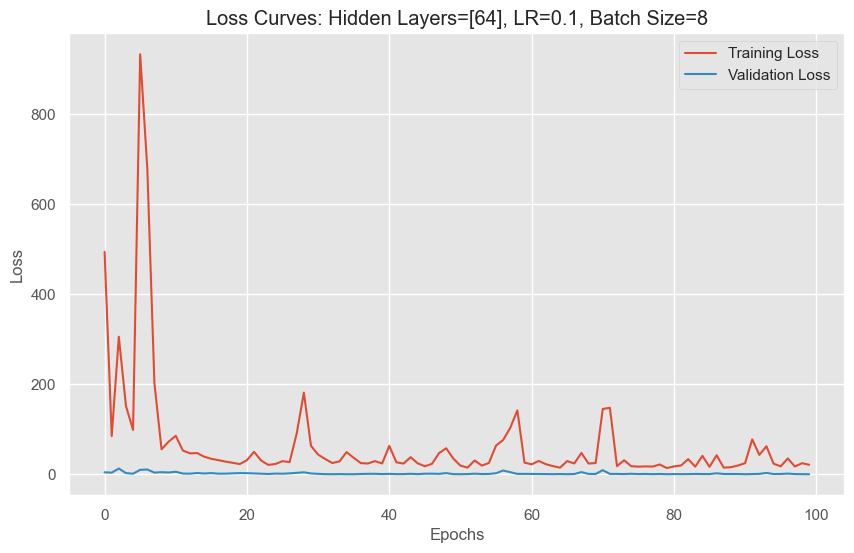

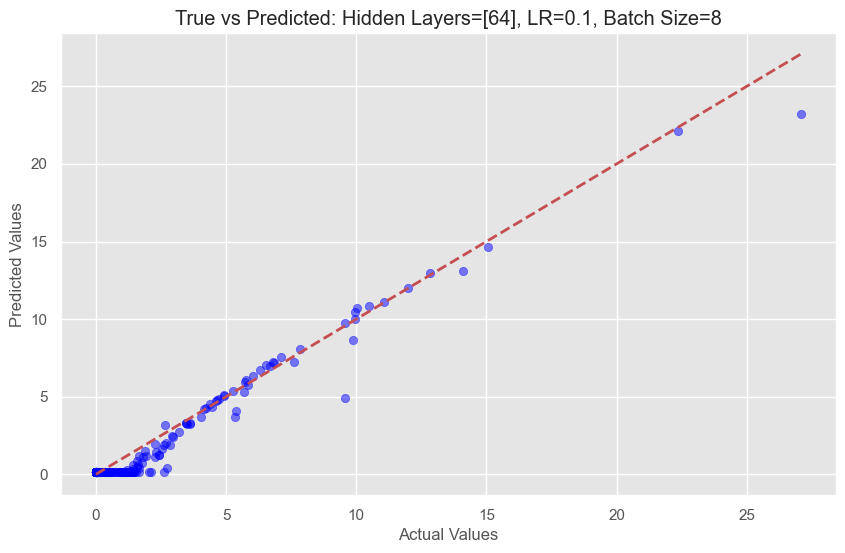


Training with hidden layers [64], learning rate 0.1 and batch size 16...

Epoch 0/100, Training Loss: 156.34894385171492, Validation Loss: 8.750956871007618
Epoch 10/100, Training Loss: 28.644624881273092, Validation Loss: 1.4998951805265326
Epoch 20/100, Training Loss: 64.04394048036531, Validation Loss: 2.278631844018635
Epoch 30/100, Training Loss: 16.63238769405803, Validation Loss: 0.940097691981416
Epoch 40/100, Training Loss: 21.222690624683057, Validation Loss: 1.0830952666307752
Epoch 50/100, Training Loss: 50.834494298280674, Validation Loss: 2.797221245734315
Epoch 60/100, Training Loss: 19.91975385695696, Validation Loss: 0.9128785674509249
Epoch 70/100, Training Loss: 17.301062893728876, Validation Loss: 0.5228865499559202
Epoch 80/100, Training Loss: 23.10910034352957, Validation Loss: 0.9341320740549188
Epoch 90/100, Training Loss: 32.01230249415303, Validation Loss: 1.129444582289771
R² Score: 0.9255


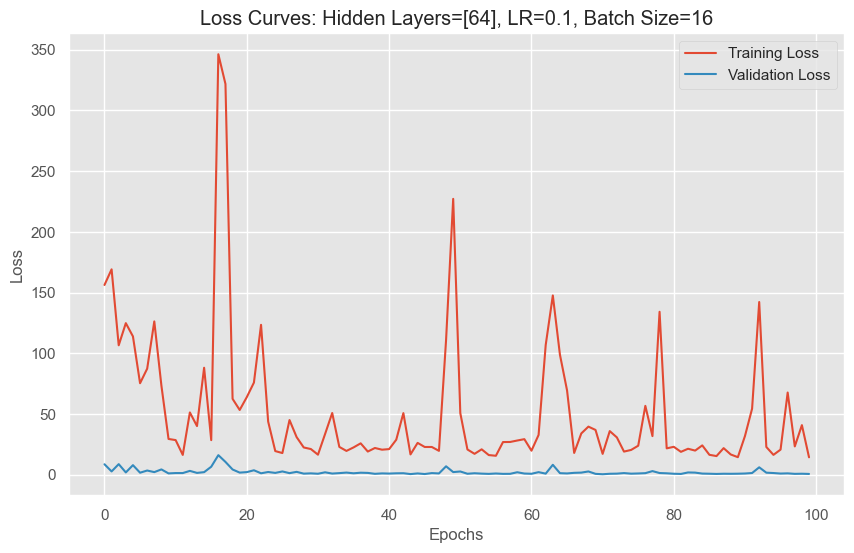

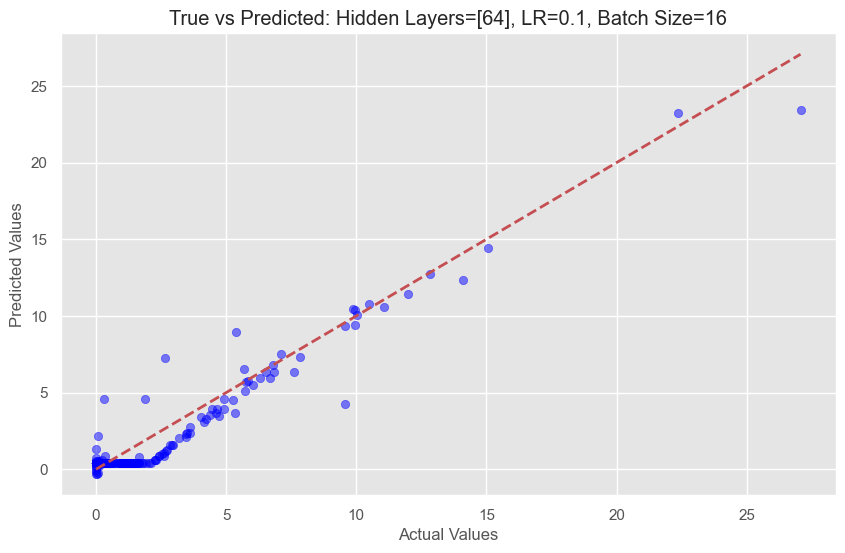


Training with hidden layers [64], learning rate 0.1 and batch size 32...

Epoch 0/100, Training Loss: 281.8164917013862, Validation Loss: 31.201407432556152
Epoch 10/100, Training Loss: 25.08070061694492, Validation Loss: 2.6018437378108503
Epoch 20/100, Training Loss: 21.50414881787517, Validation Loss: 0.935733164101839
Epoch 30/100, Training Loss: 63.03150101412427, Validation Loss: 1.9892313823103904
Epoch 40/100, Training Loss: 20.762133051048625, Validation Loss: 1.406834289431572
Epoch 50/100, Training Loss: 40.42861020835963, Validation Loss: 0.695041897892952
Epoch 60/100, Training Loss: 17.764847194606606, Validation Loss: 0.6194312155246735
Epoch 70/100, Training Loss: 16.496307786554098, Validation Loss: 0.6238991290330886
Epoch 80/100, Training Loss: 26.16236276518215, Validation Loss: 1.2505651347339153
Epoch 90/100, Training Loss: 14.648480514233762, Validation Loss: 0.5599861531984061
R² Score: 0.9525


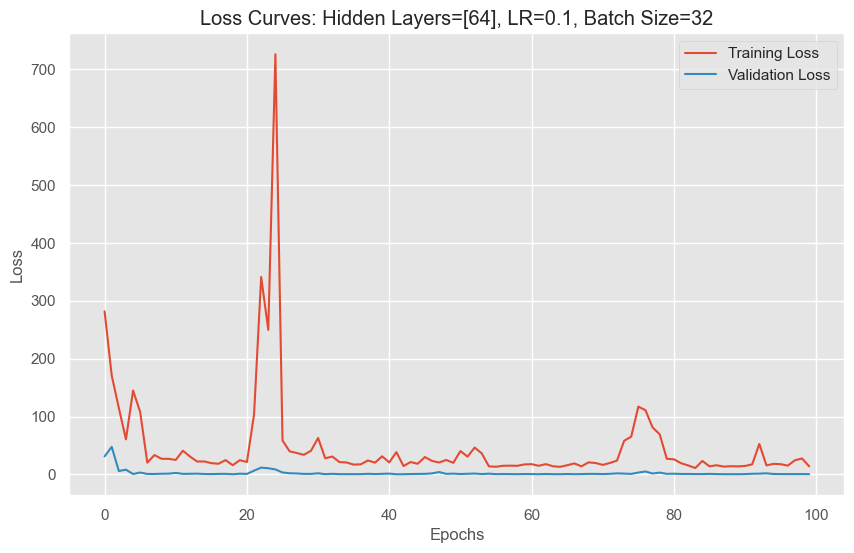

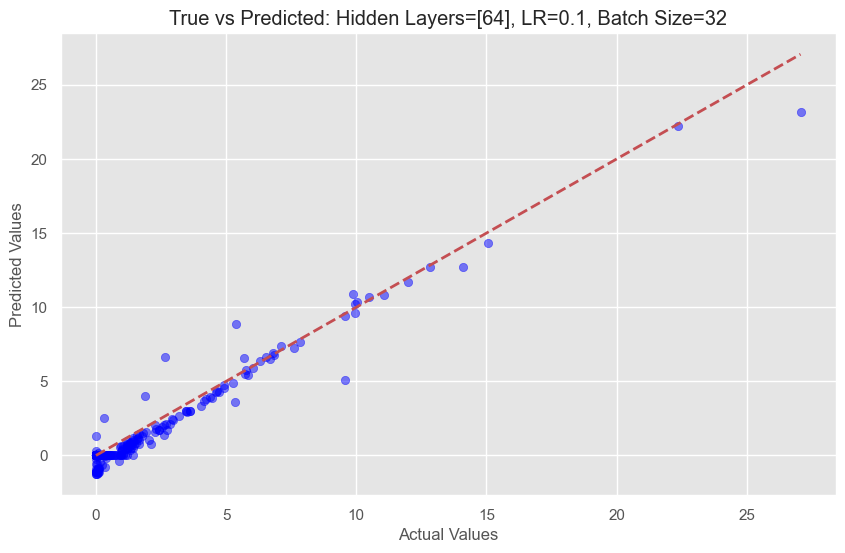


Training with hidden layers [64], learning rate 0.1 and batch size 64...

Epoch 0/100, Training Loss: 692.70068879561, Validation Loss: 22.01667175292969
Epoch 10/100, Training Loss: 120.82790709625591, Validation Loss: 2.014556407928467
Epoch 20/100, Training Loss: 19.284420923753217, Validation Loss: 0.7817734003067016
Epoch 30/100, Training Loss: 37.42113178426569, Validation Loss: 2.498100256919861
Epoch 40/100, Training Loss: 16.426106041127984, Validation Loss: 0.969936978816986
Epoch 50/100, Training Loss: 15.935325384140015, Validation Loss: 0.8797523081302643
Epoch 60/100, Training Loss: 16.314362363381818, Validation Loss: 1.6283542394638062
Epoch 70/100, Training Loss: 21.1072765073993, Validation Loss: 1.6410195589065553
Epoch 80/100, Training Loss: 13.443224137479609, Validation Loss: 1.3696731686592103
Epoch 90/100, Training Loss: 37.831988681446425, Validation Loss: 1.427747416496277
R² Score: 0.9146


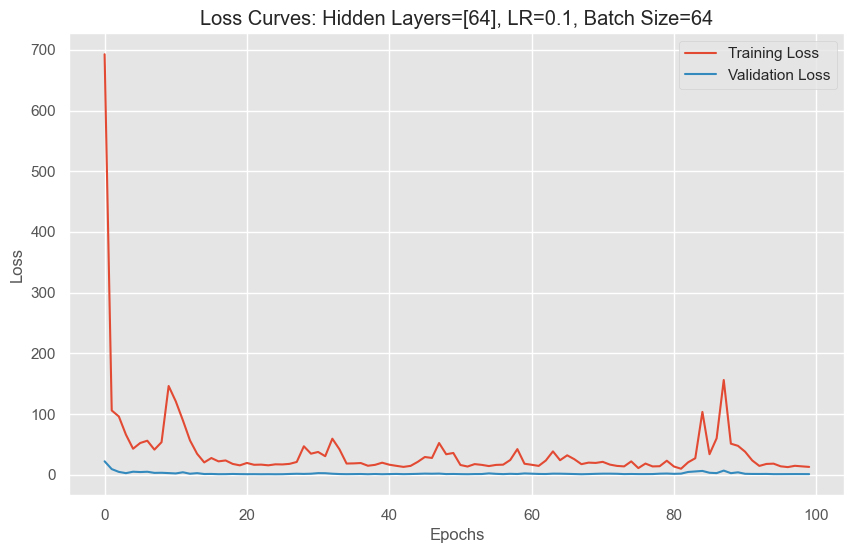

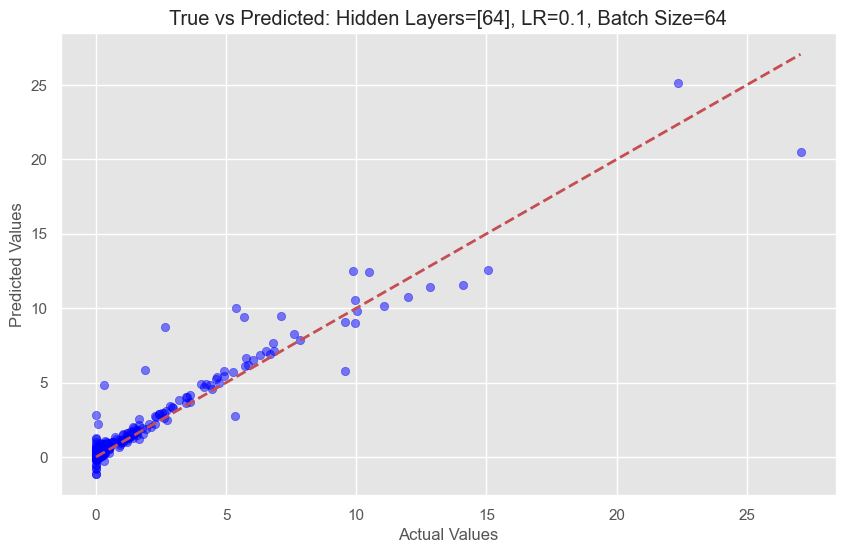


Training with hidden layers [64], learning rate 0.01 and batch size 8...

Epoch 0/100, Training Loss: 873.7743603795507, Validation Loss: 2.0175349420389614
Epoch 10/100, Training Loss: 59.645512357007625, Validation Loss: 9.74231709016336
Epoch 20/100, Training Loss: 36.88527538003616, Validation Loss: 3.586123110474767
Epoch 30/100, Training Loss: 21.8275666143312, Validation Loss: 2.772483962613183
Epoch 40/100, Training Loss: 24.998969150490538, Validation Loss: 2.563847295335821
Epoch 50/100, Training Loss: 15.657214747958404, Validation Loss: 2.1922041451608814
Epoch 60/100, Training Loss: 12.690403999630796, Validation Loss: 1.8791806037361558
Epoch 70/100, Training Loss: 11.695503274195415, Validation Loss: 3.38885519432055
Epoch 80/100, Training Loss: 7.684402269852716, Validation Loss: 1.480470303748105
Epoch 90/100, Training Loss: 6.865796390660973, Validation Loss: 1.4155024290084839
R² Score: 0.7560


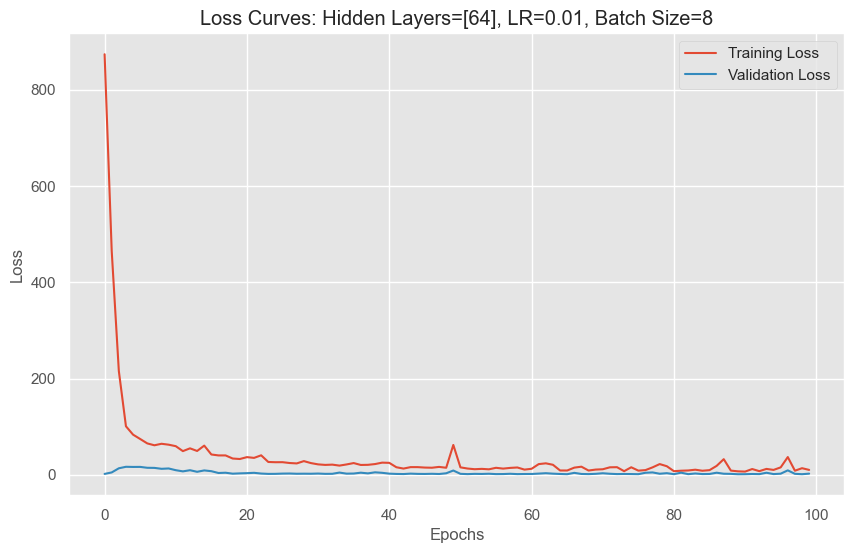

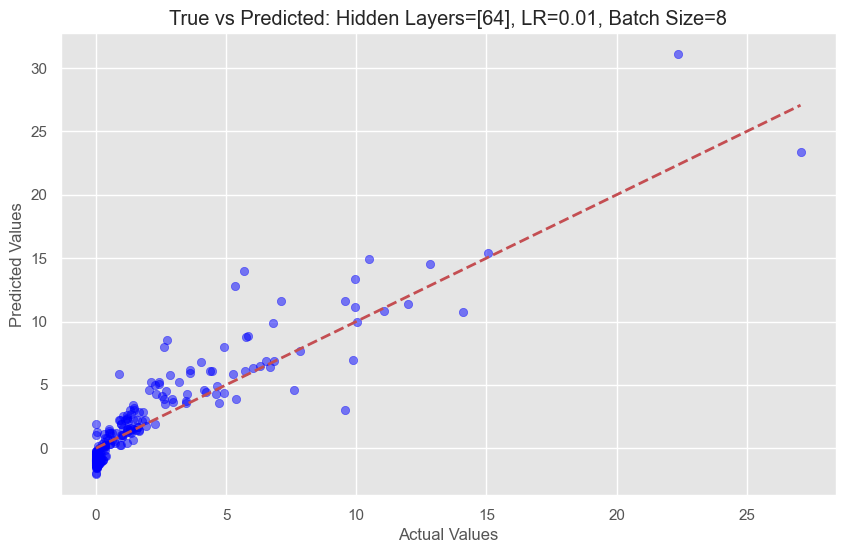


Training with hidden layers [64], learning rate 0.01 and batch size 16...

Epoch 0/100, Training Loss: 898.1872892241146, Validation Loss: 5.238550499865883
Epoch 10/100, Training Loss: 48.27628270138142, Validation Loss: 5.75348604980268
Epoch 20/100, Training Loss: 31.65371490079303, Validation Loss: 3.1846228038009845
Epoch 30/100, Training Loss: 26.588081266990926, Validation Loss: 3.148646055083526
Epoch 40/100, Training Loss: 22.004857710627622, Validation Loss: 2.873097168771844
Epoch 50/100, Training Loss: 14.846449407034141, Validation Loss: 2.456099535289564
Epoch 60/100, Training Loss: 21.865095616773118, Validation Loss: 3.2415928621041146
Epoch 70/100, Training Loss: 12.402587588443312, Validation Loss: 2.1292206746967217
Epoch 80/100, Training Loss: 10.88479820656222, Validation Loss: 2.2486791940111863
Epoch 90/100, Training Loss: 8.707568074381628, Validation Loss: 2.7845462811620614
R² Score: 0.8155


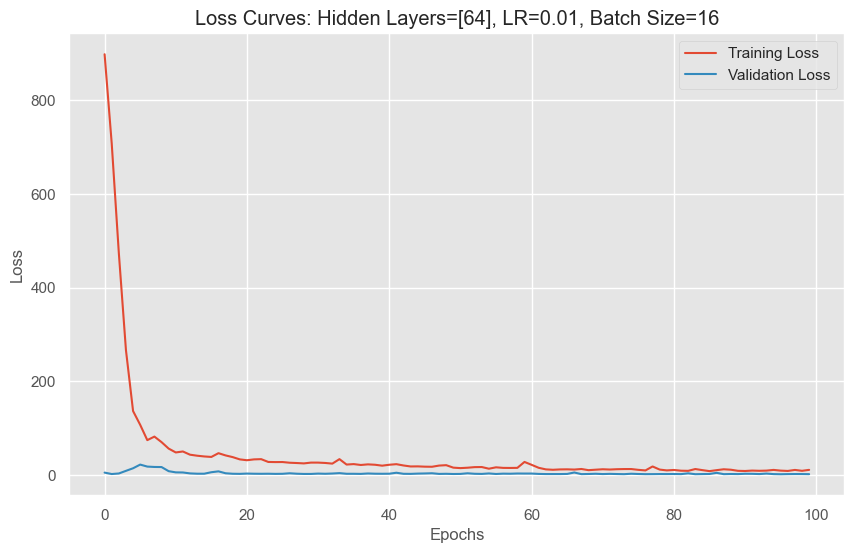

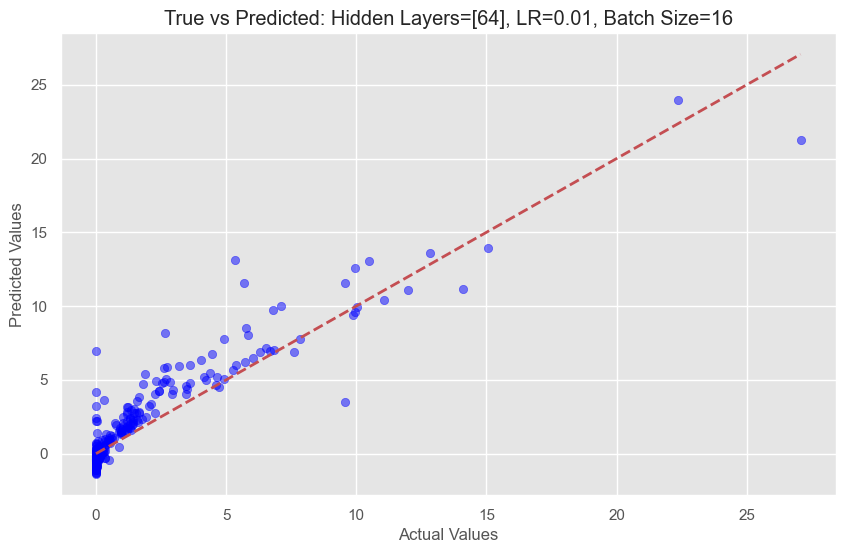


Training with hidden layers [64], learning rate 0.01 and batch size 32...

Epoch 0/100, Training Loss: 949.1517008543015, Validation Loss: 8.94596712589264
Epoch 10/100, Training Loss: 60.039901516654275, Validation Loss: 13.980226826667785
Epoch 20/100, Training Loss: 43.07339543646032, Validation Loss: 9.395211774110795
Epoch 30/100, Training Loss: 31.87207691235976, Validation Loss: 3.9690957605838775
Epoch 40/100, Training Loss: 25.533325840126384, Validation Loss: 3.2199701189994814
Epoch 50/100, Training Loss: 22.37390890175646, Validation Loss: 3.521921217441559
Epoch 60/100, Training Loss: 22.20033391497352, Validation Loss: 3.903968131542206
Epoch 70/100, Training Loss: 14.51245275546204, Validation Loss: 2.4084983229637147
Epoch 80/100, Training Loss: 12.229863172227686, Validation Loss: 1.9843104049563407
Epoch 90/100, Training Loss: 10.03118835254149, Validation Loss: 2.0158890426158904
R² Score: 0.7907


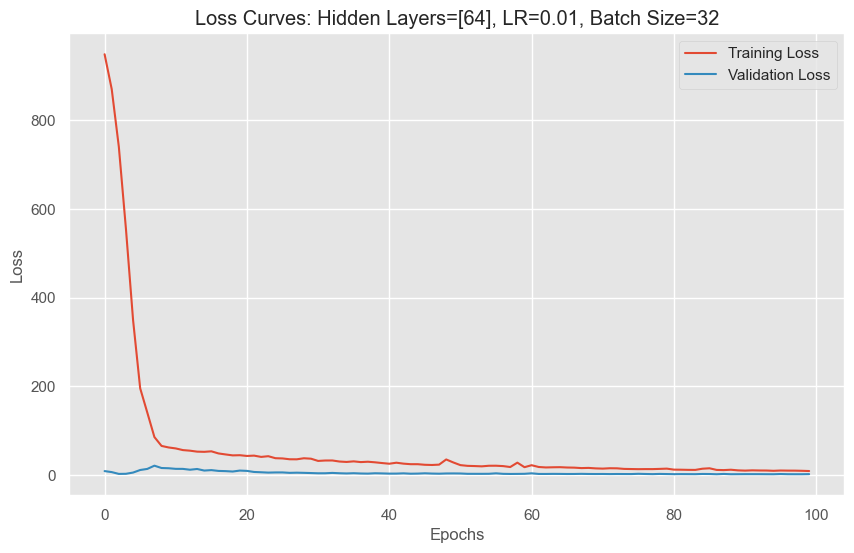

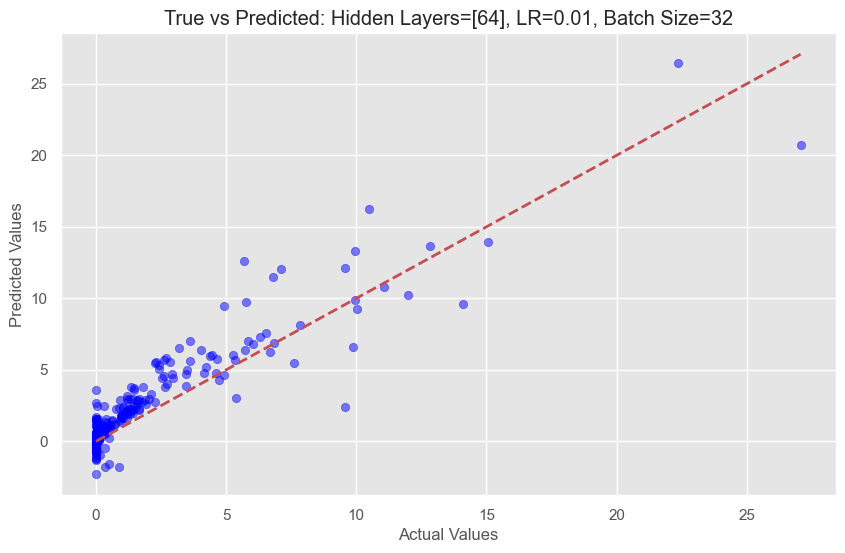


Training with hidden layers [64], learning rate 0.01 and batch size 64...

Epoch 0/100, Training Loss: 966.1159532720393, Validation Loss: 10.841119146347046
Epoch 10/100, Training Loss: 152.39613303271207, Validation Loss: 11.636771297454834
Epoch 20/100, Training Loss: 52.24828577041626, Validation Loss: 11.142271709442138
Epoch 30/100, Training Loss: 38.27807693047957, Validation Loss: 4.475930786132812
Epoch 40/100, Training Loss: 32.95734975554726, Validation Loss: 3.839824748039246
Epoch 50/100, Training Loss: 28.56689739227295, Validation Loss: 3.782480311393738
Epoch 60/100, Training Loss: 25.12726423957131, Validation Loss: 3.730340814590454
Epoch 70/100, Training Loss: 25.815234292637218, Validation Loss: 4.016851568222046
Epoch 80/100, Training Loss: 19.924067345532503, Validation Loss: 3.3303990840911863
Epoch 90/100, Training Loss: 17.599687056107953, Validation Loss: 3.368845224380493
R² Score: 0.6761


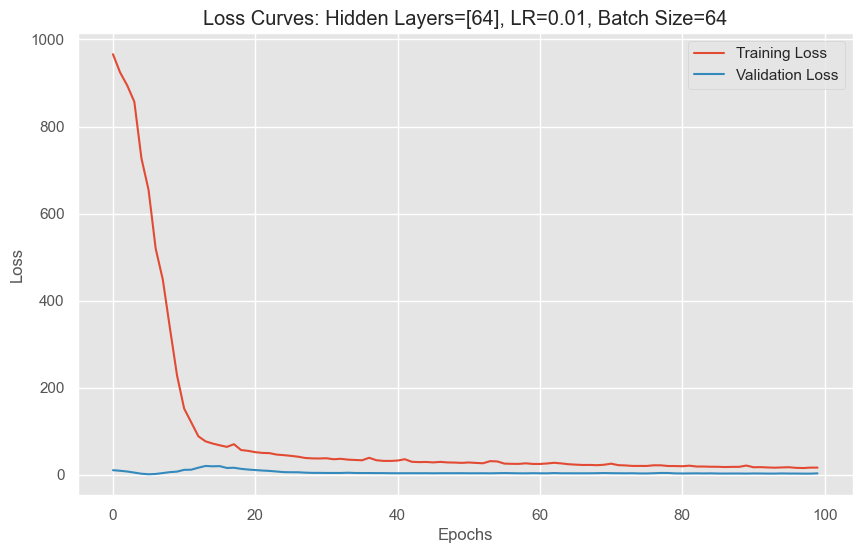

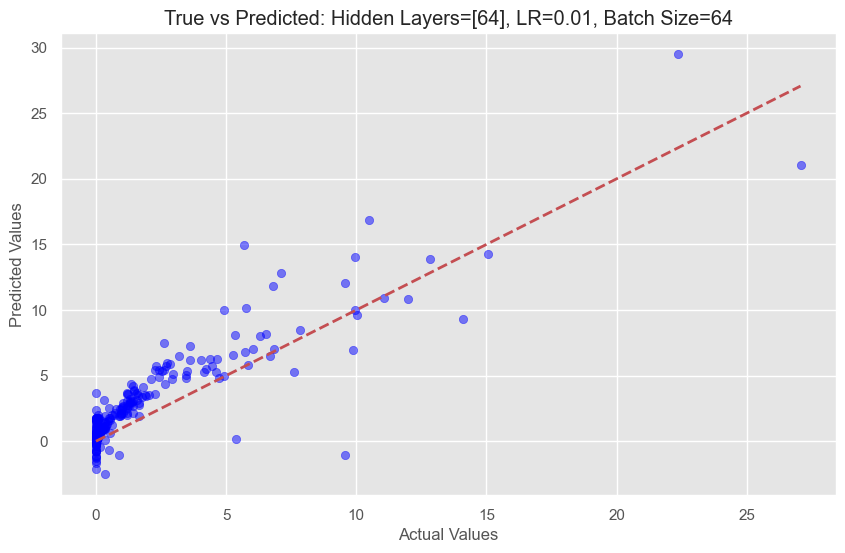


Training with hidden layers [64], learning rate 0.001 and batch size 8...

Epoch 0/100, Training Loss: 1000.2636268029726, Validation Loss: 12.072289460414165
Epoch 10/100, Training Loss: 796.0033390126083, Validation Loss: 2.8338314165940157
Epoch 20/100, Training Loss: 430.3995955725049, Validation Loss: 2.1110544494680457
Epoch 30/100, Training Loss: 181.6110613858977, Validation Loss: 8.132418635729197
Epoch 40/100, Training Loss: 89.21069902874703, Validation Loss: 15.556240958136481
Epoch 50/100, Training Loss: 67.49003440003062, Validation Loss: 19.153645489666914
Epoch 60/100, Training Loss: 61.156520578750346, Validation Loss: 17.011196342674463
Epoch 70/100, Training Loss: 51.04129415889119, Validation Loss: 9.736263771314878
Epoch 80/100, Training Loss: 41.90959909073142, Validation Loss: 5.7367055883278715
Epoch 90/100, Training Loss: 37.14900081916604, Validation Loss: 3.574579908235653
R² Score: 0.7255


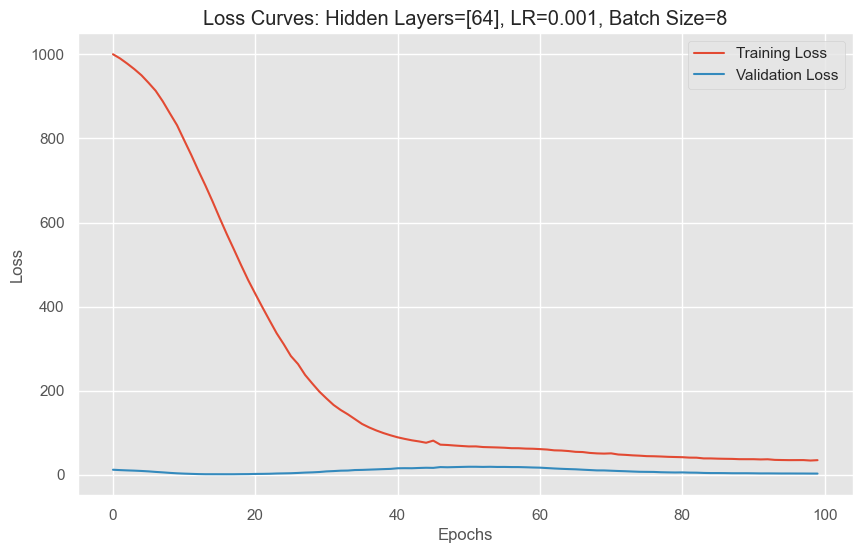

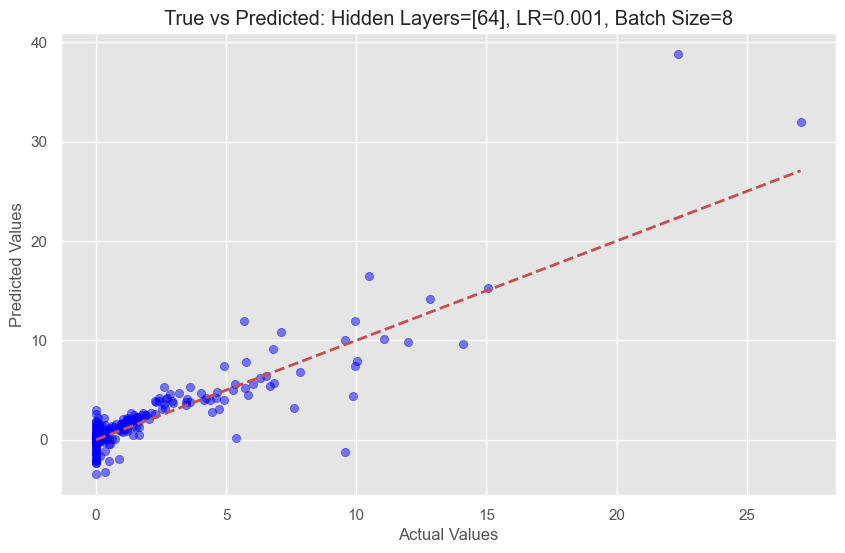


Training with hidden layers [64], learning rate 0.001 and batch size 16...

Epoch 0/100, Training Loss: 1013.7779700645181, Validation Loss: 12.942700023713865
Epoch 10/100, Training Loss: 870.5173855728881, Validation Loss: 5.294547909968777
Epoch 20/100, Training Loss: 588.3870178537313, Validation Loss: 1.337279255452909
Epoch 30/100, Training Loss: 323.43838284181993, Validation Loss: 2.9237096152807536
Epoch 40/100, Training Loss: 157.80768436332082, Validation Loss: 7.793681521164744
Epoch 50/100, Training Loss: 89.37465357225994, Validation Loss: 13.293587860308195
Epoch 60/100, Training Loss: 68.88323757260345, Validation Loss: 16.757783362739964
Epoch 70/100, Training Loss: 60.0183137294858, Validation Loss: 13.589888346822638
Epoch 80/100, Training Loss: 49.355746876361756, Validation Loss: 8.118282267921849
Epoch 90/100, Training Loss: 42.73832604496978, Validation Loss: 4.84358695306276
R² Score: 0.6361


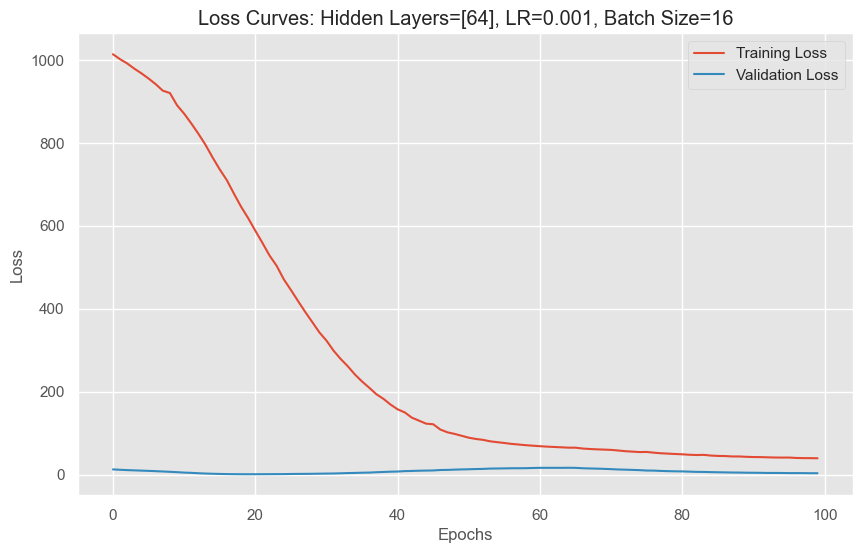

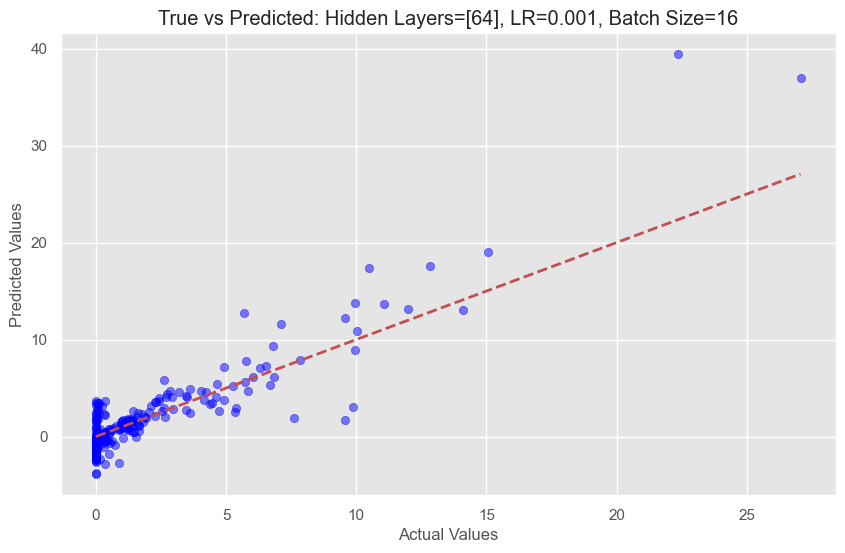


Training with hidden layers [64], learning rate 0.001 and batch size 32...

Epoch 0/100, Training Loss: 969.7670791799372, Validation Loss: 11.05765296369791
Epoch 10/100, Training Loss: 875.305454806848, Validation Loss: 7.023624223470688
Epoch 20/100, Training Loss: 711.6121997711333, Validation Loss: 2.4036336094141006
Epoch 30/100, Training Loss: 512.3752996677703, Validation Loss: 1.7157108724117278
Epoch 40/100, Training Loss: 333.24935752695256, Validation Loss: 3.3729318141937257
Epoch 50/100, Training Loss: 200.4863751368089, Validation Loss: 5.386420810222626
Epoch 60/100, Training Loss: 121.00522528995167, Validation Loss: 9.323780798912049
Epoch 70/100, Training Loss: 84.1713808666576, Validation Loss: 12.6001727104187
Epoch 80/100, Training Loss: 68.29833379658785, Validation Loss: 14.494265699386597
Epoch 90/100, Training Loss: 62.451224933971055, Validation Loss: 14.937224817276
R² Score: -0.4051


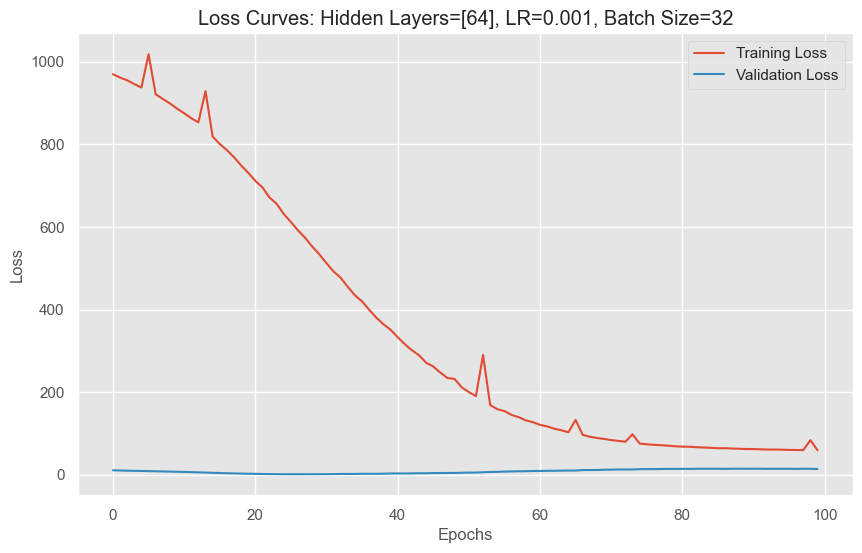

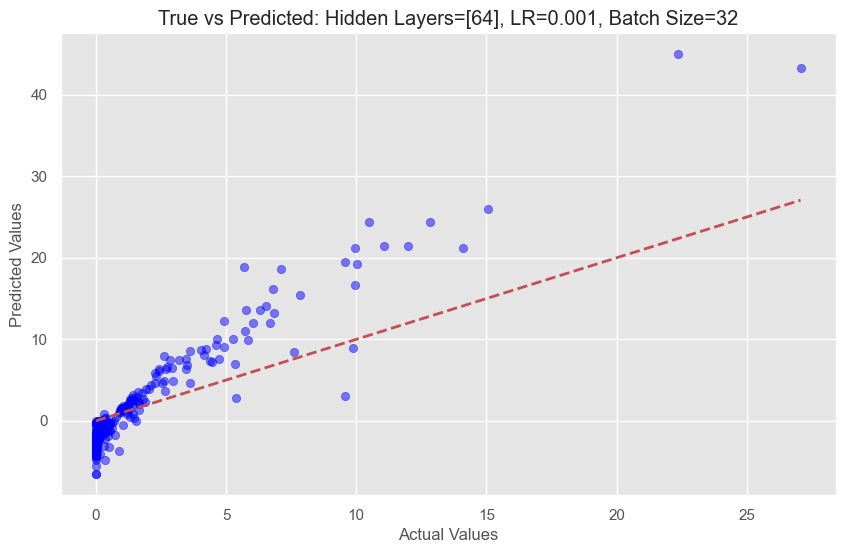


Training with hidden layers [64], learning rate 0.001 and batch size 64...

Epoch 0/100, Training Loss: 968.7980401732705, Validation Loss: 11.957492876052857
Epoch 10/100, Training Loss: 932.5957287875088, Validation Loss: 9.38303074836731
Epoch 20/100, Training Loss: 986.8366298675537, Validation Loss: 6.571580791473389
Epoch 30/100, Training Loss: 742.5555972186002, Validation Loss: 3.650306224822998
Epoch 40/100, Training Loss: 627.676651651209, Validation Loss: 1.9320059299468995
Epoch 50/100, Training Loss: 505.83991025794637, Validation Loss: 2.1768075466156005
Epoch 60/100, Training Loss: 390.72912086140025, Validation Loss: 3.1345778942108153
Epoch 70/100, Training Loss: 288.34716231172735, Validation Loss: 4.139761209487915
Epoch 80/100, Training Loss: 209.44397323781794, Validation Loss: 5.599419021606446
Epoch 90/100, Training Loss: 148.8643237027255, Validation Loss: 8.253392314910888
R² Score: 0.0009


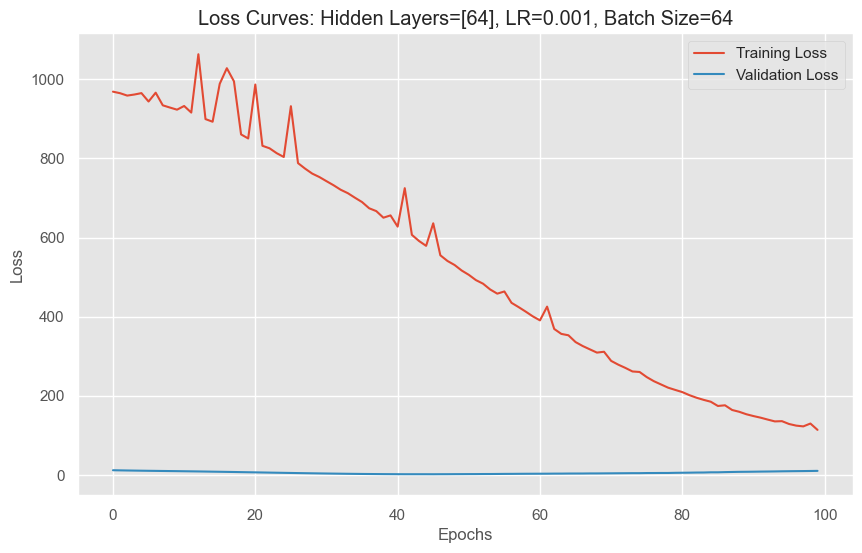

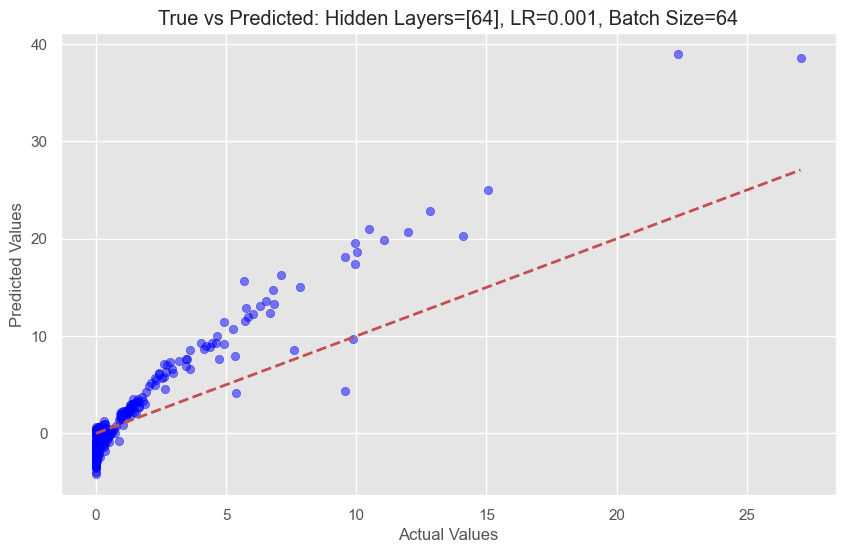


Training with hidden layers [128, 64], learning rate 0.1 and batch size 8...

Epoch 0/100, Training Loss: 754.494017097146, Validation Loss: 11.91728827666894
Epoch 10/100, Training Loss: 981.1722604285839, Validation Loss: 19.160903621364284
Epoch 20/100, Training Loss: 981.5808882047963, Validation Loss: 19.428985286403346
Epoch 30/100, Training Loss: 981.1808696458506, Validation Loss: 19.35335009806865
Epoch 40/100, Training Loss: 981.375243763591, Validation Loss: 18.380825558224238
Epoch 50/100, Training Loss: 981.2677313782448, Validation Loss: 21.968857249698125
Epoch 60/100, Training Loss: 981.0209895289222, Validation Loss: 19.455578340066445
Epoch 70/100, Training Loss: 1010.4481028068898, Validation Loss: 16.46694379239469
Epoch 80/100, Training Loss: 981.0362490387851, Validation Loss: 20.322323051658838
Epoch 90/100, Training Loss: 981.3804715400519, Validation Loss: 18.579370086257523
R² Score: -0.9081


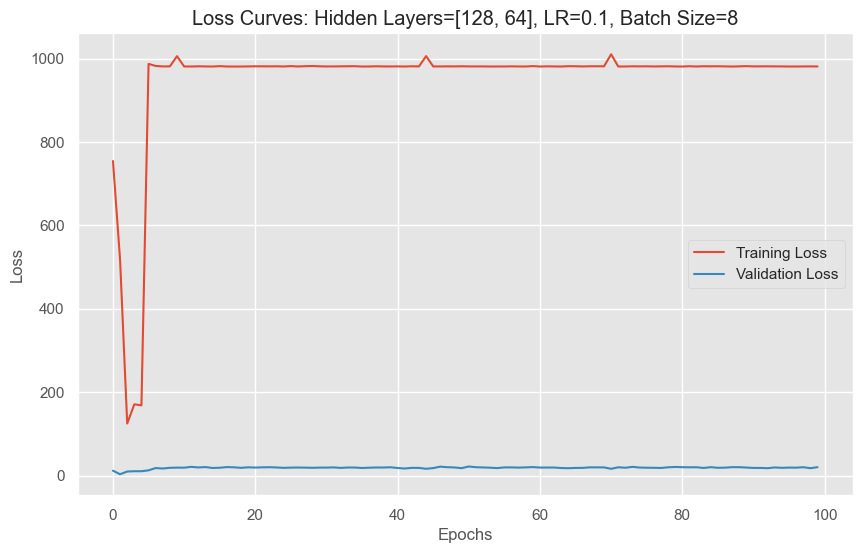

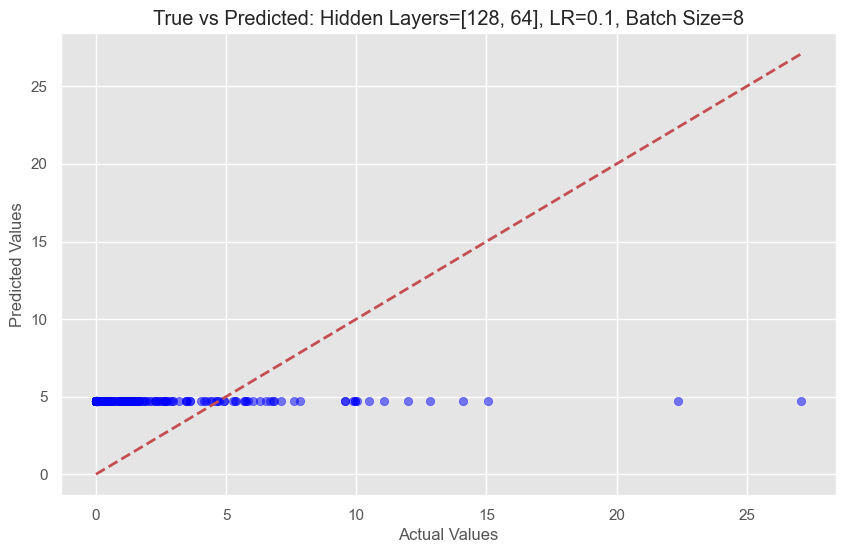


Training with hidden layers [128, 64], learning rate 0.1 and batch size 16...

Epoch 0/100, Training Loss: 947.062342106603, Validation Loss: 15.41623013897946
Epoch 10/100, Training Loss: 990.1340951323509, Validation Loss: 10.510986139899806
Epoch 20/100, Training Loss: 904.1591054658558, Validation Loss: 3.051986382195824
Epoch 30/100, Training Loss: 823.3040762862494, Validation Loss: 3.859890191178573
Epoch 40/100, Training Loss: 774.7407314264497, Validation Loss: 8.706554538325259
Epoch 50/100, Training Loss: 721.7848888124491, Validation Loss: 3.573181813484744
Epoch 60/100, Training Loss: 682.5095579825169, Validation Loss: 5.6084589750358935
Epoch 70/100, Training Loss: 677.1584324313458, Validation Loss: 6.126354041852449
Epoch 80/100, Training Loss: 616.827882021319, Validation Loss: 5.581701033993771
Epoch 90/100, Training Loss: 591.3767695972739, Validation Loss: 9.969114299275374
R² Score: -0.6395


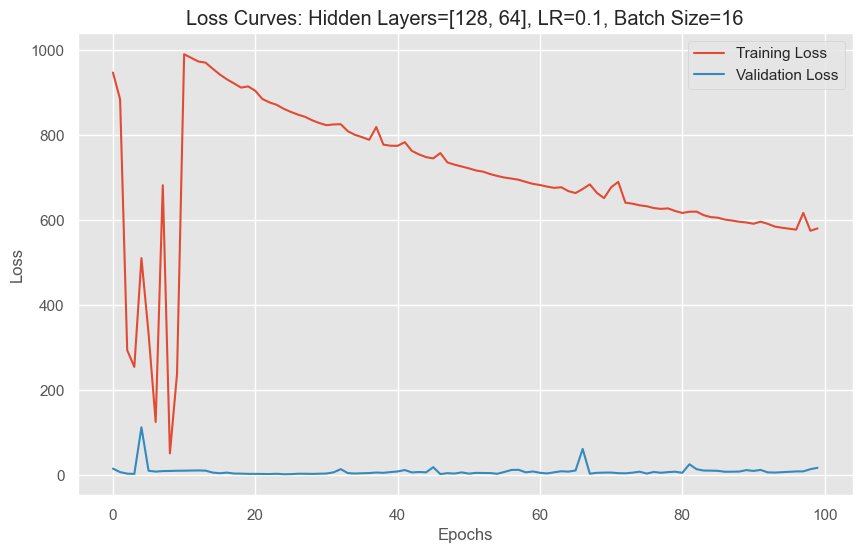

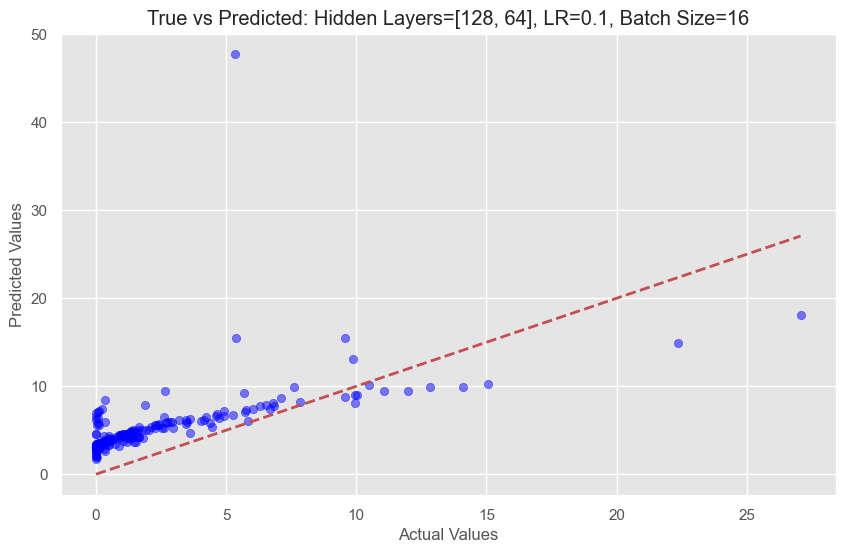


Training with hidden layers [128, 64], learning rate 0.1 and batch size 32...

Epoch 0/100, Training Loss: 655.0927568023855, Validation Loss: 5.936661796271801
Epoch 10/100, Training Loss: 236.78845728527415, Validation Loss: 6.514633174240589
Epoch 20/100, Training Loss: 28.04365104165944, Validation Loss: 3.650910052657127
Epoch 30/100, Training Loss: 42.69778944145549, Validation Loss: 2.7107018932700155
Epoch 40/100, Training Loss: 20.36638448455117, Validation Loss: 3.150581020116806
Epoch 50/100, Training Loss: 8.62784358452667, Validation Loss: 2.069894953072071
Epoch 60/100, Training Loss: 6.59799386696382, Validation Loss: 1.7346034780144692
Epoch 70/100, Training Loss: 23.002216803756628, Validation Loss: 1.789001253247261
Epoch 80/100, Training Loss: 6.978107434782115, Validation Loss: 1.5053349938243628
Epoch 90/100, Training Loss: 25.130168183283374, Validation Loss: 1.2311673015356064
R² Score: 0.8057


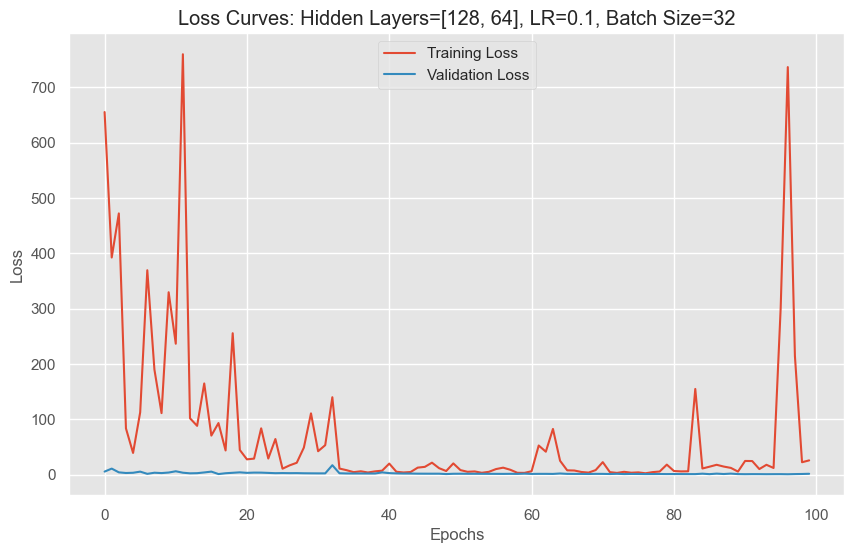

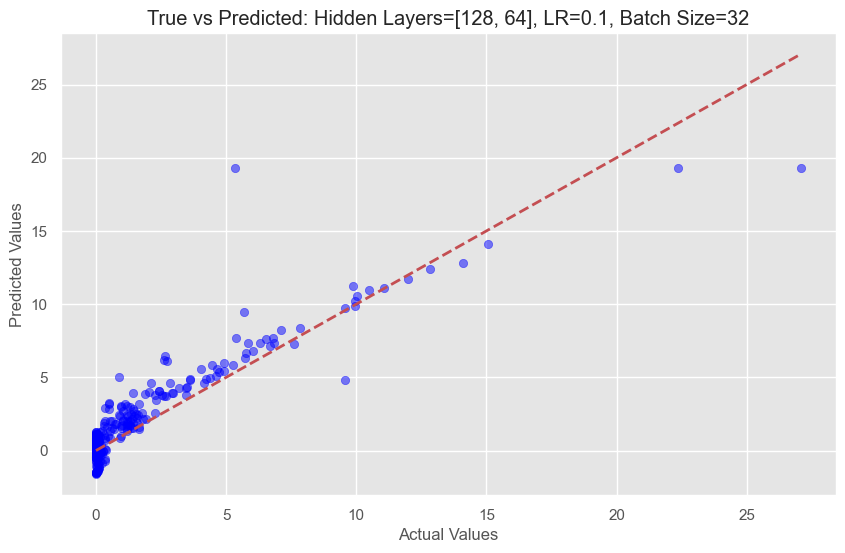


Training with hidden layers [128, 64], learning rate 0.1 and batch size 64...

Epoch 0/100, Training Loss: 758.8697638945146, Validation Loss: 22.803283500671387
Epoch 10/100, Training Loss: 13.686950575221669, Validation Loss: 2.2673731803894044
Epoch 20/100, Training Loss: 56.130054994062945, Validation Loss: 10.548507785797119
Epoch 30/100, Training Loss: 78.80403395132585, Validation Loss: 4.527955508232116
Epoch 40/100, Training Loss: 7.277738354422829, Validation Loss: 3.2467506885528565
Epoch 50/100, Training Loss: 1.9901467832652004, Validation Loss: 1.743513786792755
Epoch 60/100, Training Loss: 1.032075983556834, Validation Loss: 1.467142915725708
Epoch 70/100, Training Loss: 140.79522280259565, Validation Loss: 3.9126153588294983
Epoch 80/100, Training Loss: 1.8098603974689136, Validation Loss: 2.682807558774948
Epoch 90/100, Training Loss: 1.43586019765247, Validation Loss: 1.9962675392627716
R² Score: 0.4995


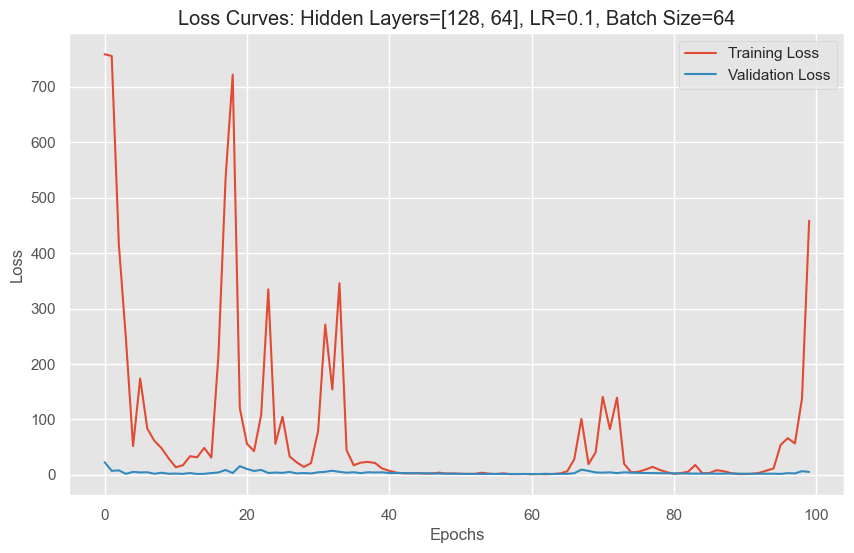

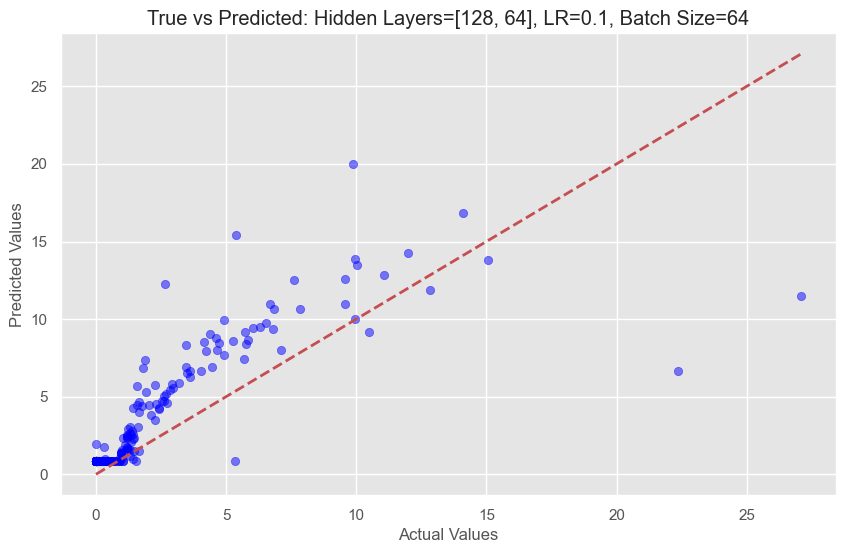


Training with hidden layers [128, 64], learning rate 0.01 and batch size 8...

Epoch 0/100, Training Loss: 556.1311869087607, Validation Loss: 3.6068245301375517
Epoch 10/100, Training Loss: 153.17957449936156, Validation Loss: 0.6699991155717824
Epoch 20/100, Training Loss: 26.570130341188158, Validation Loss: 1.2093590687255602
Epoch 30/100, Training Loss: 6.280116229004031, Validation Loss: 0.5467929779992413
Epoch 40/100, Training Loss: 6.7964803364214506, Validation Loss: 0.8353141284472233
Epoch 50/100, Training Loss: 163.36010104495773, Validation Loss: 11.970129347129449
Epoch 60/100, Training Loss: 4.2108114160770596, Validation Loss: 0.8995357604848372
Epoch 70/100, Training Loss: 2.4065194563117136, Validation Loss: 1.0590157637725006
Epoch 80/100, Training Loss: 75.86487809499336, Validation Loss: 1.755708718622053
Epoch 90/100, Training Loss: 4.0997464072912235, Validation Loss: 1.0334708114733566
R² Score: 0.8889


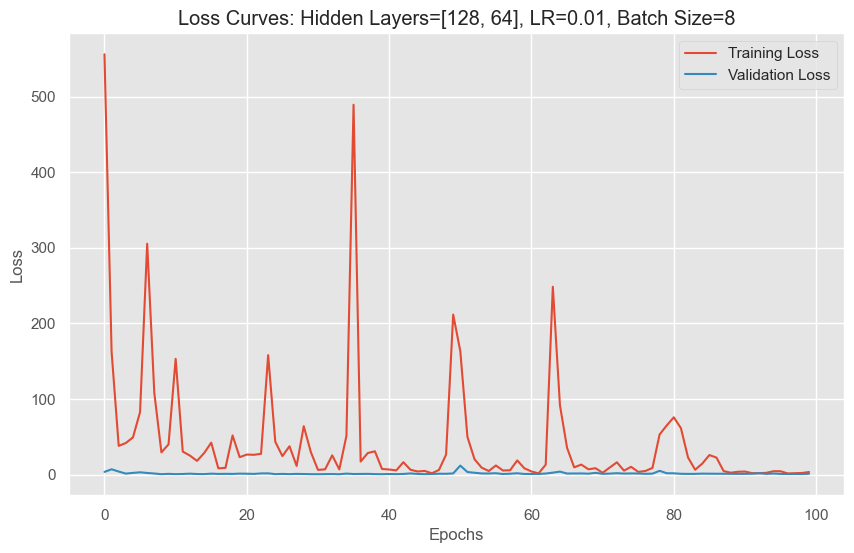

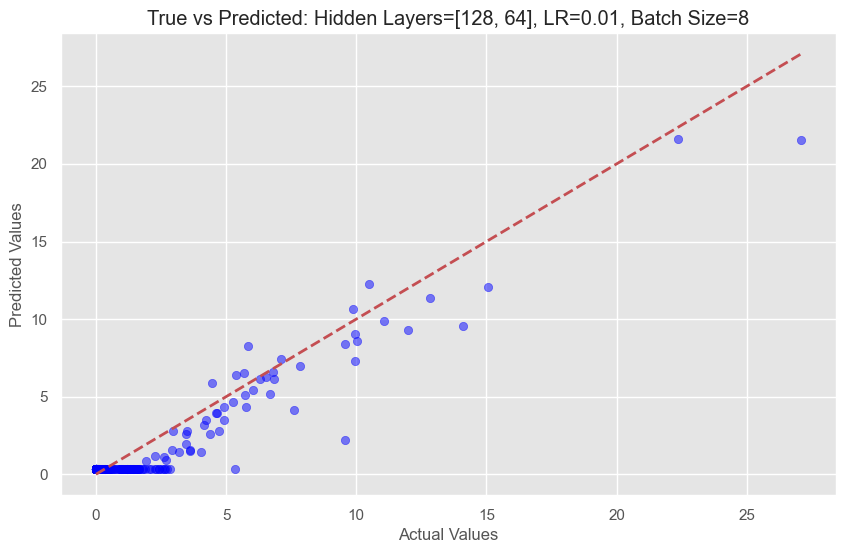


Training with hidden layers [128, 64], learning rate 0.01 and batch size 16...

Epoch 0/100, Training Loss: 798.3475736562423, Validation Loss: 2.974506098973124
Epoch 10/100, Training Loss: 13.756617440733798, Validation Loss: 1.1684241716406847
Epoch 20/100, Training Loss: 122.80834477013627, Validation Loss: 3.1821437242784
Epoch 30/100, Training Loss: 4.536455656033616, Validation Loss: 0.3846973478794098
Epoch 40/100, Training Loss: 1.5742097385660854, Validation Loss: 0.36670132329393373
Epoch 50/100, Training Loss: 37.15184157246421, Validation Loss: 0.48619980374841315
Epoch 60/100, Training Loss: 226.5301906320938, Validation Loss: 6.360746010353691
Epoch 70/100, Training Loss: 1.2939751860577353, Validation Loss: 0.4123772212157124
Epoch 80/100, Training Loss: 1.2290863957429348, Validation Loss: 0.687237689761739
Epoch 90/100, Training Loss: 19.460587058996044, Validation Loss: 0.8751254519937854
R² Score: 0.8885


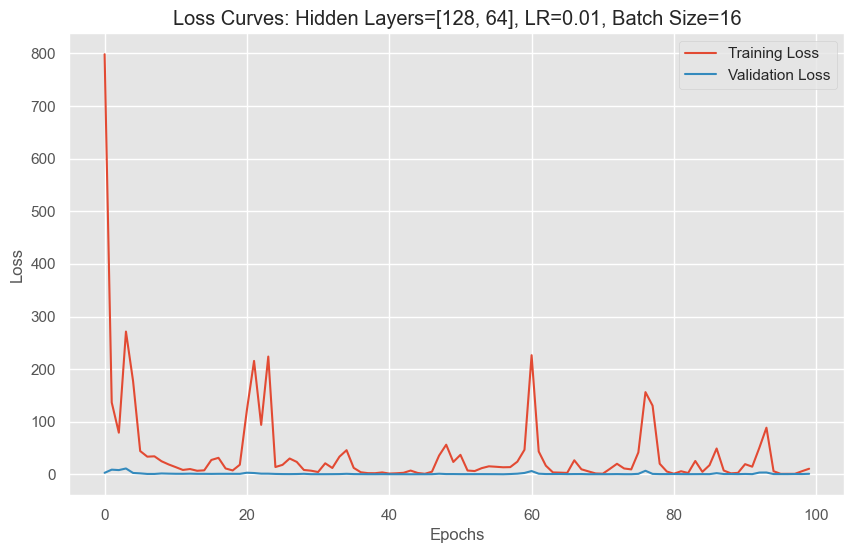

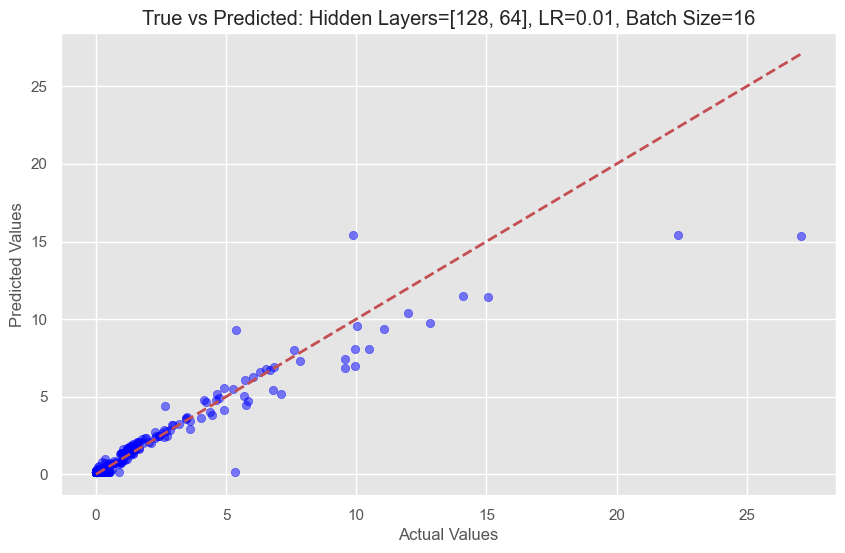


Training with hidden layers [128, 64], learning rate 0.01 and batch size 32...

Epoch 0/100, Training Loss: 676.86364124038, Validation Loss: 4.152335464954376
Epoch 10/100, Training Loss: 23.29182558709925, Validation Loss: 1.3408033072948455
Epoch 20/100, Training Loss: 120.10754716938192, Validation Loss: 1.9495833396911622
Epoch 30/100, Training Loss: 7.946078667925163, Validation Loss: 1.1829831138253213
Epoch 40/100, Training Loss: 3.4822884418747644, Validation Loss: 0.7240723691880703
Epoch 50/100, Training Loss: 82.94750724326481, Validation Loss: 2.5001961469650267
Epoch 60/100, Training Loss: 1.923685389824889, Validation Loss: 0.46410425438079983
Epoch 70/100, Training Loss: 2.6451927249065856, Validation Loss: 0.369625748321414
Epoch 80/100, Training Loss: 1.217720976607366, Validation Loss: 0.47817855328321457
Epoch 90/100, Training Loss: 1.0695155505937608, Validation Loss: 0.38177956733852625
R² Score: 0.9666


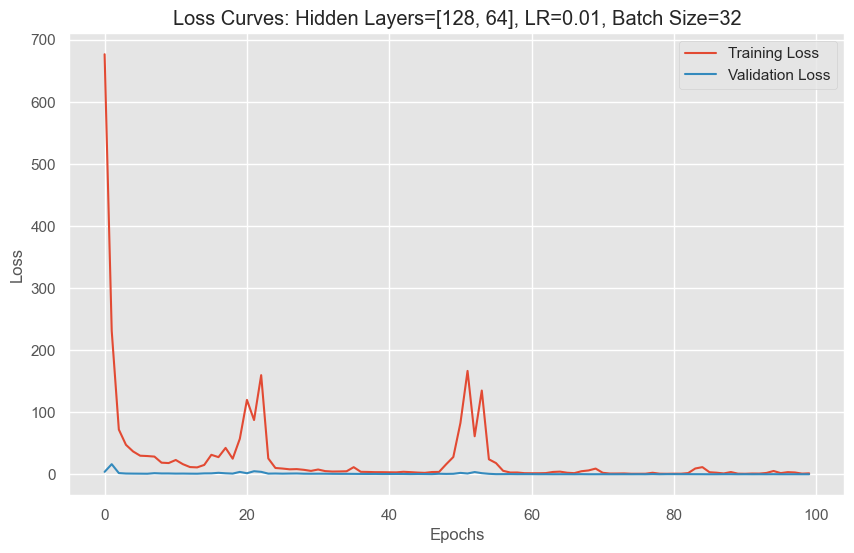

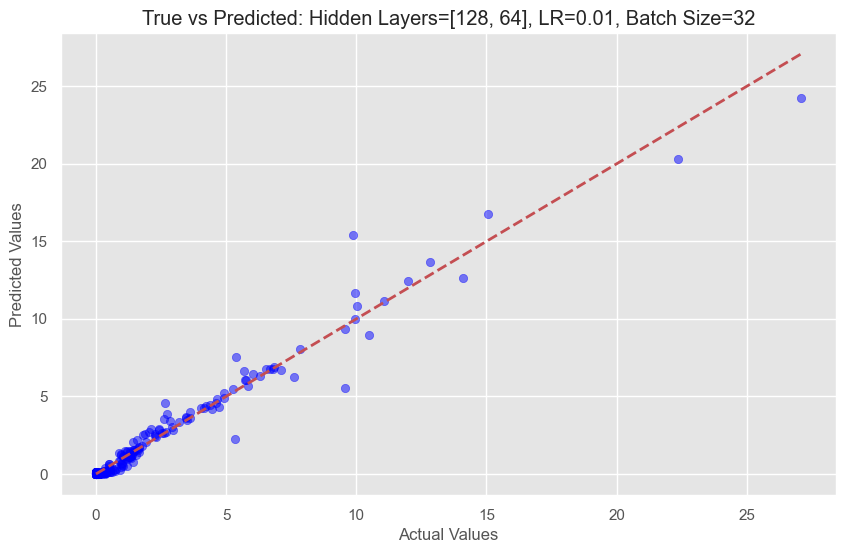


Training with hidden layers [128, 64], learning rate 0.01 and batch size 64...

Epoch 0/100, Training Loss: 829.8033780184659, Validation Loss: 8.924693584442139
Epoch 10/100, Training Loss: 28.080180406570435, Validation Loss: 5.339434480667114
Epoch 20/100, Training Loss: 12.196269902316006, Validation Loss: 1.3699705719947814
Epoch 30/100, Training Loss: 3.902508779005571, Validation Loss: 0.7131309807300568
Epoch 40/100, Training Loss: 324.79110557382756, Validation Loss: 1.8349750638008118
Epoch 50/100, Training Loss: 2.8169398944486272, Validation Loss: 0.6664649665355682
Epoch 60/100, Training Loss: 1.3689898455684835, Validation Loss: 0.5599623829126358
Epoch 70/100, Training Loss: 1.342734611847184, Validation Loss: 0.4804371356964111
Epoch 80/100, Training Loss: 1.6464925096793608, Validation Loss: 0.5449607700109482
Epoch 90/100, Training Loss: 4.294259916652333, Validation Loss: 0.47452429234981536
R² Score: 0.9637


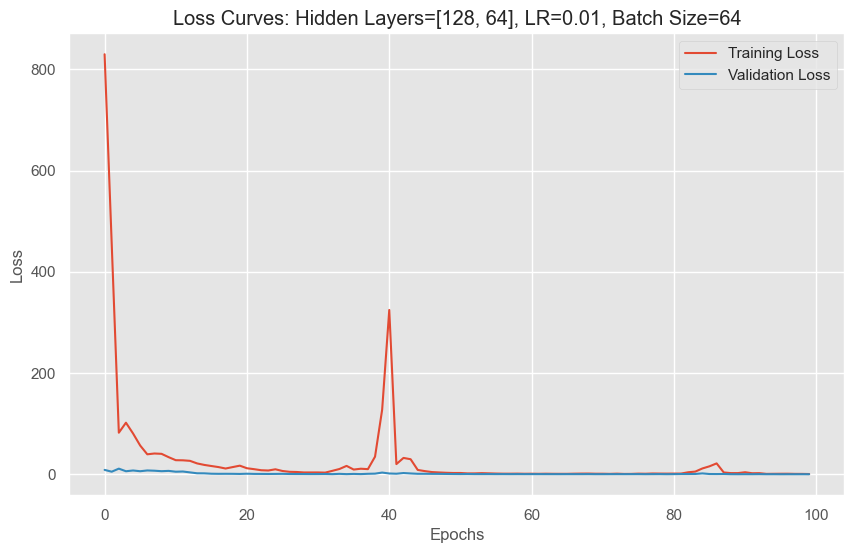

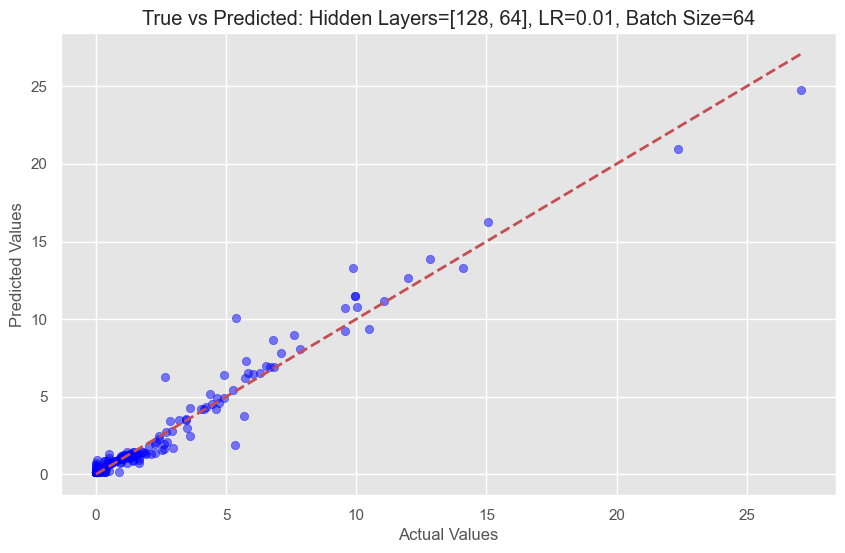


Training with hidden layers [128, 64], learning rate 0.001 and batch size 8...

Epoch 0/100, Training Loss: 936.688629501131, Validation Loss: 8.30027165686762
Epoch 10/100, Training Loss: 51.53090208197056, Validation Loss: 3.0130364165918246
Epoch 20/100, Training Loss: 34.920527813690825, Validation Loss: 1.6048982921685722
Epoch 30/100, Training Loss: 28.998505489944026, Validation Loss: 1.1578585934397336
Epoch 40/100, Training Loss: 27.627796882113746, Validation Loss: 1.9479541504705273
Epoch 50/100, Training Loss: 19.164406667961632, Validation Loss: 2.163129247523643
Epoch 60/100, Training Loss: 15.676126844401276, Validation Loss: 2.486458179515761
Epoch 70/100, Training Loss: 14.92563260771161, Validation Loss: 1.5124872806104455
Epoch 80/100, Training Loss: 13.721281567978304, Validation Loss: 1.8580951207392924
Epoch 90/100, Training Loss: 8.80155564931243, Validation Loss: 1.5823669375197307
R² Score: 0.8272


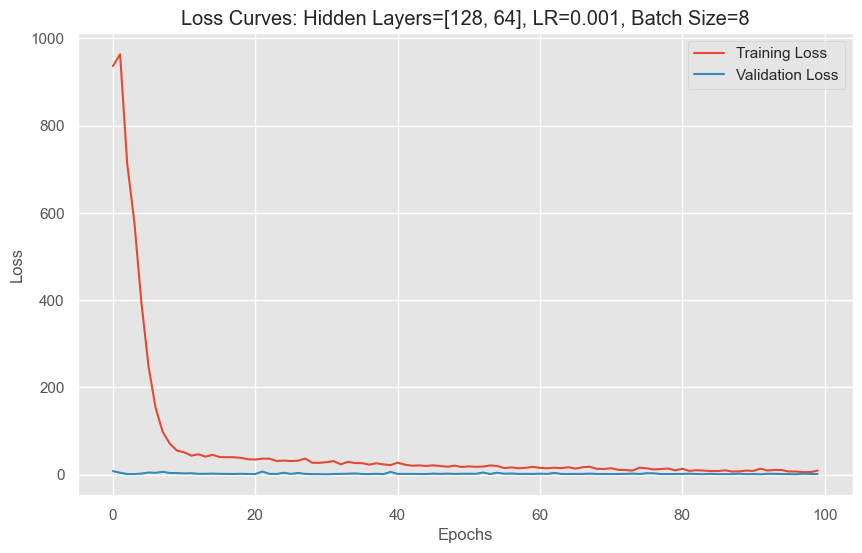

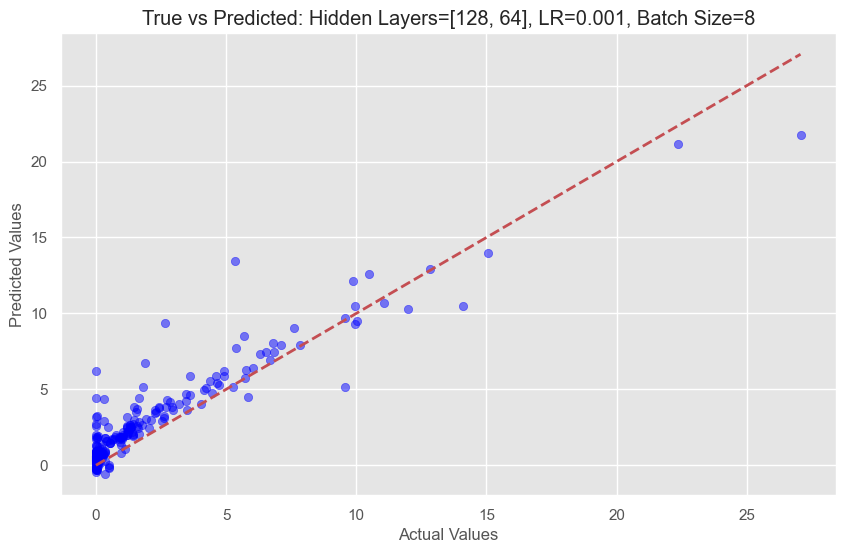


Training with hidden layers [128, 64], learning rate 0.001 and batch size 16...

Epoch 0/100, Training Loss: 964.6405466015256, Validation Loss: 9.859142055636958
Epoch 10/100, Training Loss: 62.81094336163166, Validation Loss: 2.205807606248479
Epoch 20/100, Training Loss: 32.35841144170872, Validation Loss: 0.5128390869419825
Epoch 30/100, Training Loss: 22.54592640420725, Validation Loss: 0.7228068458406549
Epoch 40/100, Training Loss: 17.360335126692473, Validation Loss: 0.9112206187687422
Epoch 50/100, Training Loss: 13.07574918727542, Validation Loss: 0.9206776477788624
Epoch 60/100, Training Loss: 10.186283735341805, Validation Loss: 0.9029137217684796
Epoch 70/100, Training Loss: 8.234515320769576, Validation Loss: 0.940464165649916
Epoch 80/100, Training Loss: 8.23955670414969, Validation Loss: 1.183481708953255
Epoch 90/100, Training Loss: 6.186943827326908, Validation Loss: 0.9118781717200029
R² Score: 0.8968


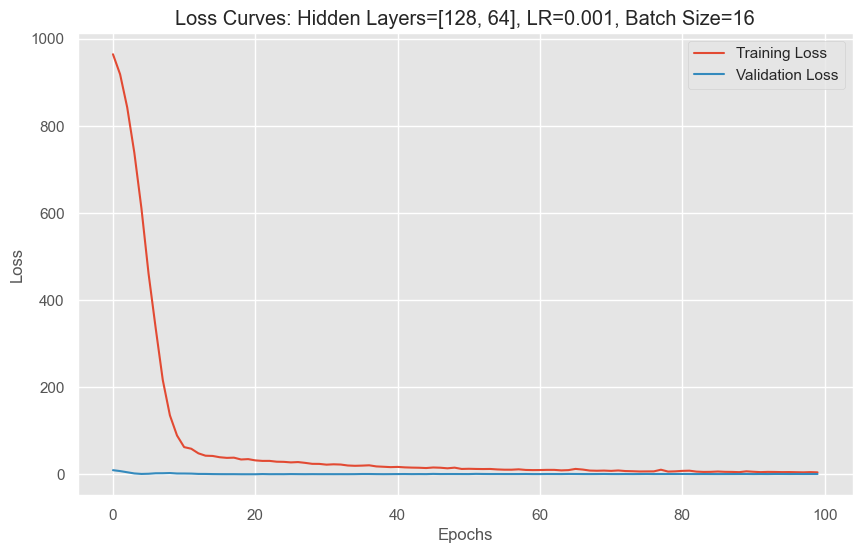

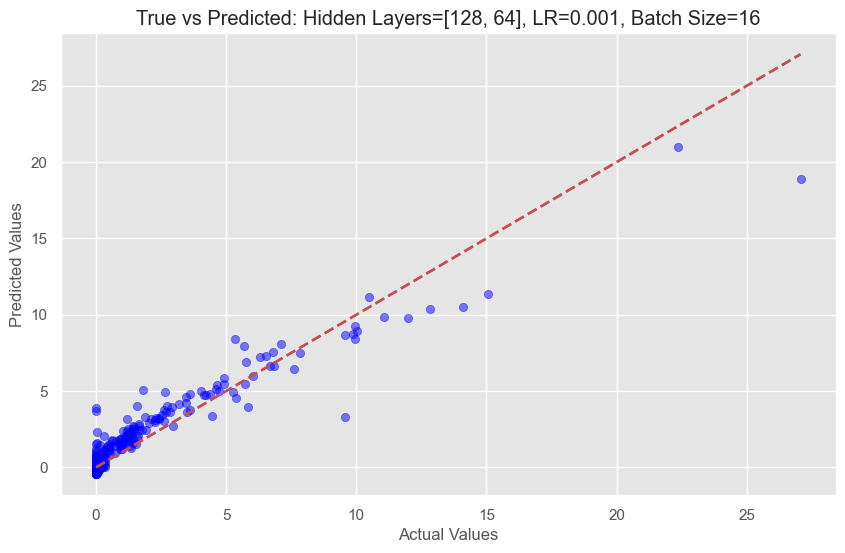


Training with hidden layers [128, 64], learning rate 0.001 and batch size 32...

Epoch 0/100, Training Loss: 961.5781411040913, Validation Loss: 10.158321964740754
Epoch 10/100, Training Loss: 198.4103250395168, Validation Loss: 3.2329047188162803
Epoch 20/100, Training Loss: 40.30875274471261, Validation Loss: 1.2087697803974151
Epoch 30/100, Training Loss: 27.169698367741976, Validation Loss: 0.5921836268156767
Epoch 40/100, Training Loss: 20.92822189662944, Validation Loss: 0.6825525786727666
Epoch 50/100, Training Loss: 15.964221885258501, Validation Loss: 0.8661255963146687
Epoch 60/100, Training Loss: 13.557928894053806, Validation Loss: 1.0037788778543473
Epoch 70/100, Training Loss: 11.432987940582363, Validation Loss: 0.9916937291622162
Epoch 80/100, Training Loss: 9.063702428882772, Validation Loss: 1.1364818945527078
Epoch 90/100, Training Loss: 7.504702700809999, Validation Loss: 1.0603377595543861
R² Score: 0.8760


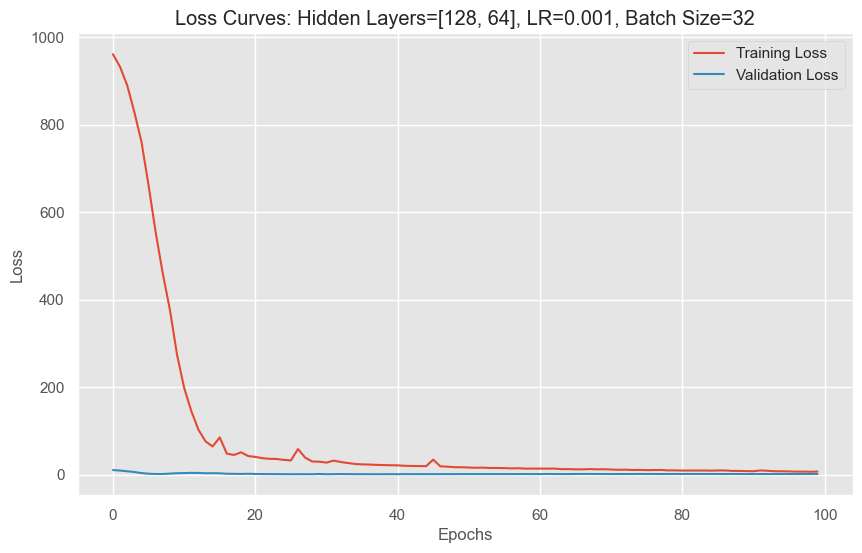

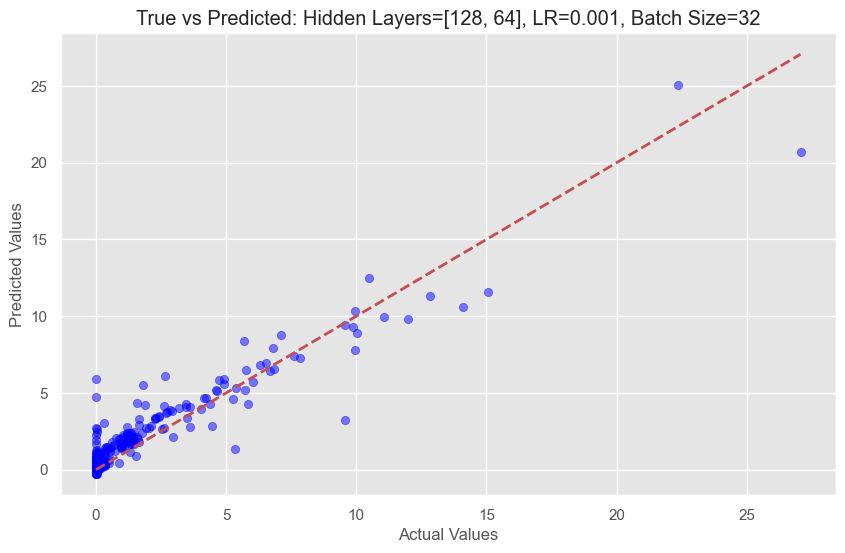


Training with hidden layers [128, 64], learning rate 0.001 and batch size 64...

Epoch 0/100, Training Loss: 972.257472298362, Validation Loss: 11.587801933288574
Epoch 10/100, Training Loss: 523.6498257138512, Validation Loss: 1.0031119585037231
Epoch 20/100, Training Loss: 75.50385015661067, Validation Loss: 9.898658180236817
Epoch 30/100, Training Loss: 43.16185274991122, Validation Loss: 4.751340007781982
Epoch 40/100, Training Loss: 34.69966386123137, Validation Loss: 2.2298419713974
Epoch 50/100, Training Loss: 28.757564295421947, Validation Loss: 1.4822625041007995
Epoch 60/100, Training Loss: 23.96686838431792, Validation Loss: 1.3318888545036316
Epoch 70/100, Training Loss: 22.03286795724522, Validation Loss: 1.421524953842163
Epoch 80/100, Training Loss: 18.298156835816123, Validation Loss: 1.2158220887184144
Epoch 90/100, Training Loss: 16.12289903380654, Validation Loss: 1.3132623195648194
R² Score: 0.8531


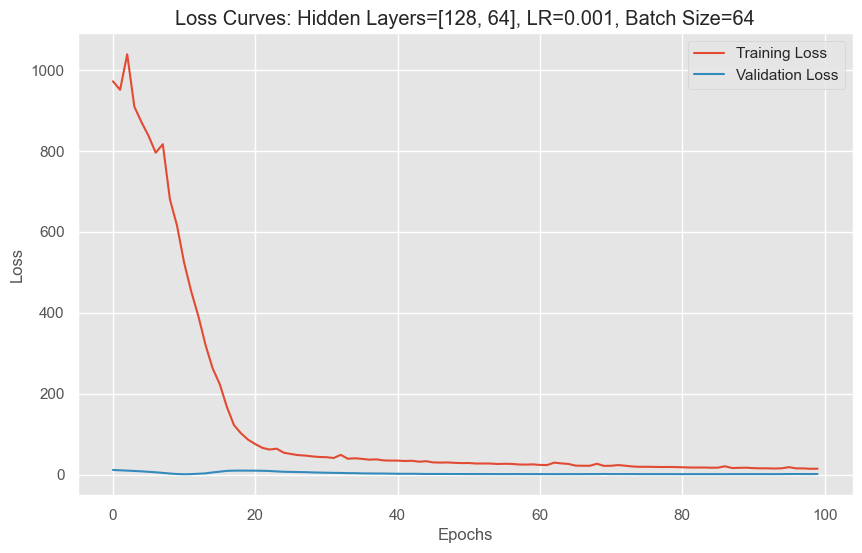

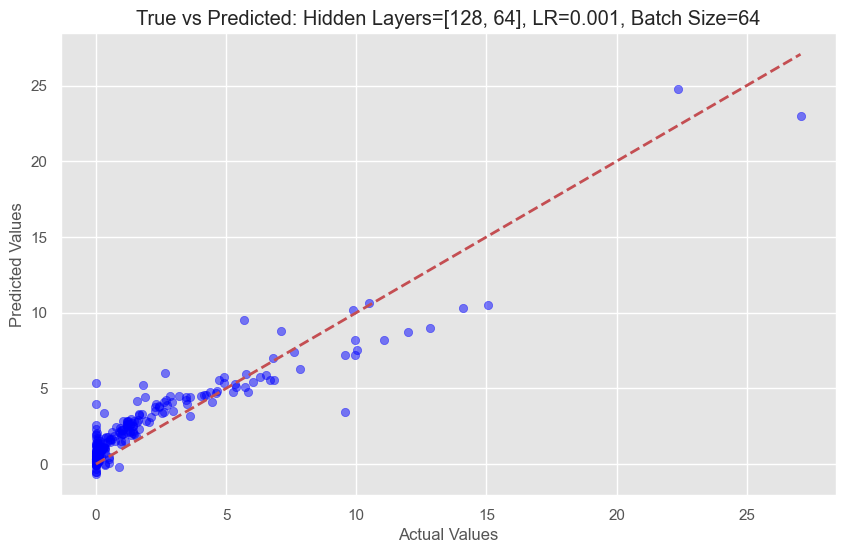


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 8...

Epoch 0/100, Training Loss: 4662.537440127065, Validation Loss: 6.412092795243135
Epoch 10/100, Training Loss: 987.0829433396805, Validation Loss: 19.02807480580098
Epoch 20/100, Training Loss: 981.8692030795785, Validation Loss: 18.461556589281237
Epoch 30/100, Training Loss: 981.0982479938241, Validation Loss: 20.87174181036047
Epoch 40/100, Training Loss: 981.5697262453479, Validation Loss: 19.088745168737464
Epoch 50/100, Training Loss: 981.8550960075023, Validation Loss: 20.257785384719437
Epoch 60/100, Training Loss: 982.312808330669, Validation Loss: 20.181890281471045
Epoch 70/100, Training Loss: 981.0365330895712, Validation Loss: 19.79970478367161
Epoch 80/100, Training Loss: 981.5916662770649, Validation Loss: 20.53558437244312
Epoch 90/100, Training Loss: 981.4096582656683, Validation Loss: 19.695821091935443
R² Score: -0.8423


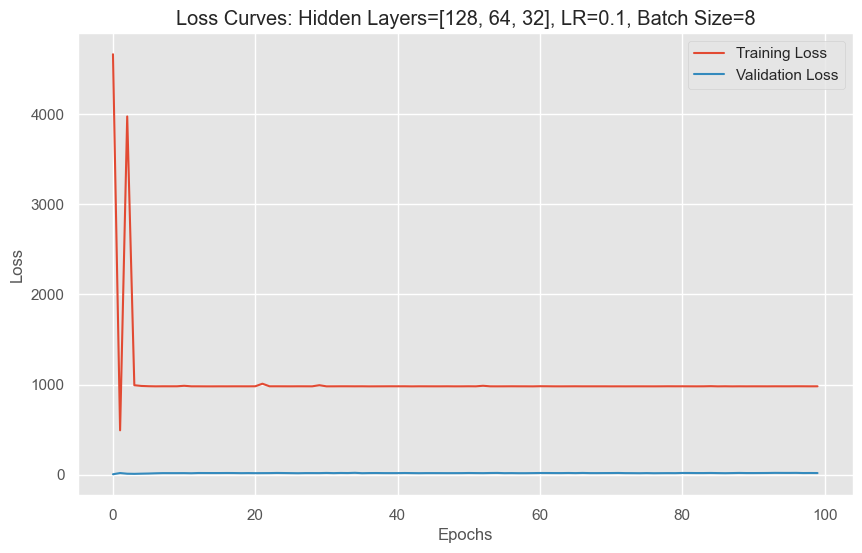

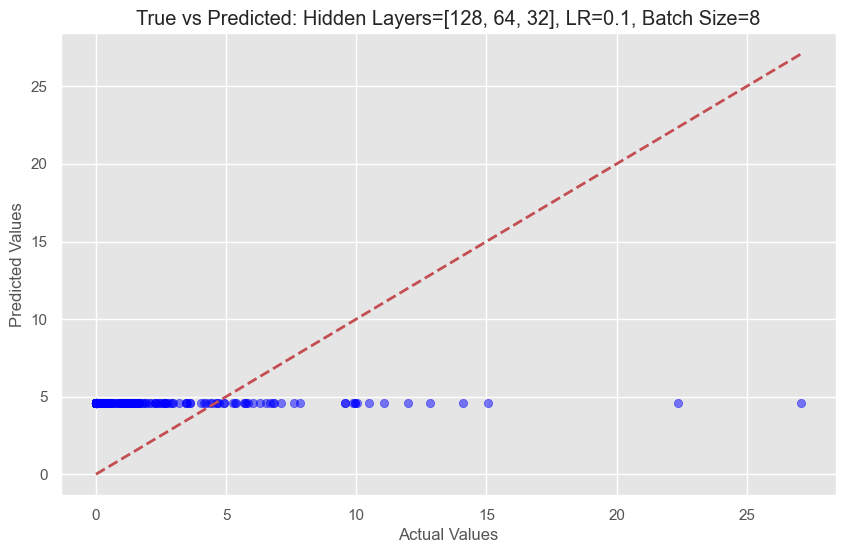


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 16...

Epoch 0/100, Training Loss: 563.5397784876269, Validation Loss: 12.140882945374438
Epoch 10/100, Training Loss: 980.9923560120338, Validation Loss: 18.64942731355366
Epoch 20/100, Training Loss: 980.7515883334847, Validation Loss: 19.715893444262054
Epoch 30/100, Training Loss: 980.9440005768178, Validation Loss: 19.95217860372443
Epoch 40/100, Training Loss: 981.2689922909404, Validation Loss: 19.13970415215743
Epoch 50/100, Training Loss: 980.8014301921046, Validation Loss: 20.067563307912724
Epoch 60/100, Training Loss: 982.4381025669187, Validation Loss: 19.344505410445365
Epoch 70/100, Training Loss: 1042.567783222642, Validation Loss: 18.058861481515986
Epoch 80/100, Training Loss: 980.6413719931314, Validation Loss: 19.828579300328304
Epoch 90/100, Training Loss: 980.8656106327855, Validation Loss: 19.32374251516242
R² Score: -0.8484


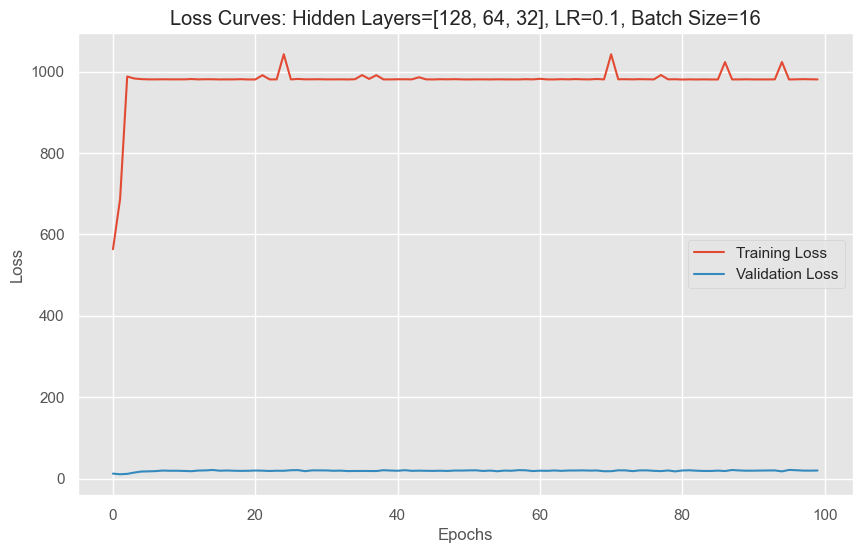

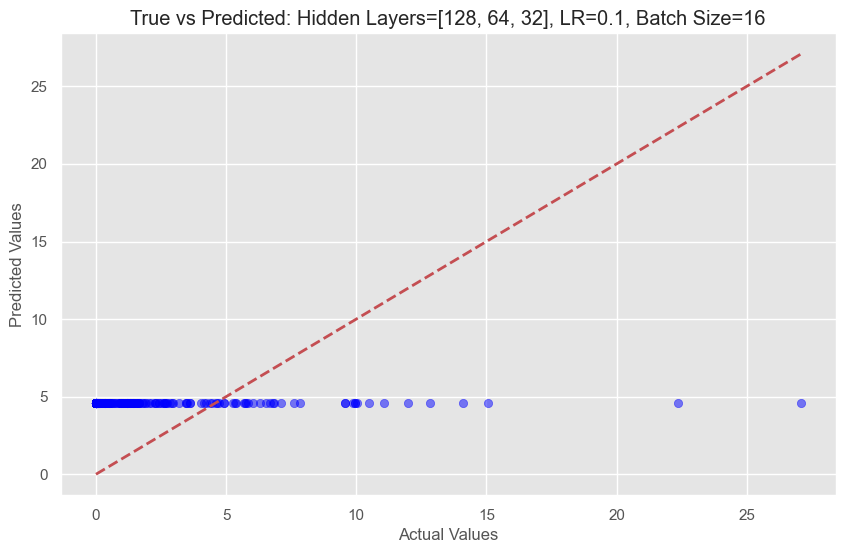


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 32...

Epoch 0/100, Training Loss: 566.1642812707207, Validation Loss: 5.2295615673065186
Epoch 10/100, Training Loss: 959.9339293566617, Validation Loss: 18.482088375091553
Epoch 20/100, Training Loss: 958.8650097413497, Validation Loss: 19.041246700286866
Epoch 30/100, Training Loss: 1050.0570508783514, Validation Loss: 19.48190689086914
Epoch 40/100, Training Loss: 959.0852604345841, Validation Loss: 20.183978652954103
Epoch 50/100, Training Loss: 958.8052649064498, Validation Loss: 18.81275987625122
Epoch 60/100, Training Loss: 959.000268762762, Validation Loss: 20.01785001754761
Epoch 70/100, Training Loss: 1502.527903253382, Validation Loss: 18.84319610595703
Epoch 80/100, Training Loss: 972.9632861830971, Validation Loss: 18.55020875930786
Epoch 90/100, Training Loss: 958.6841312755238, Validation Loss: 19.580332565307618
R² Score: -0.8170


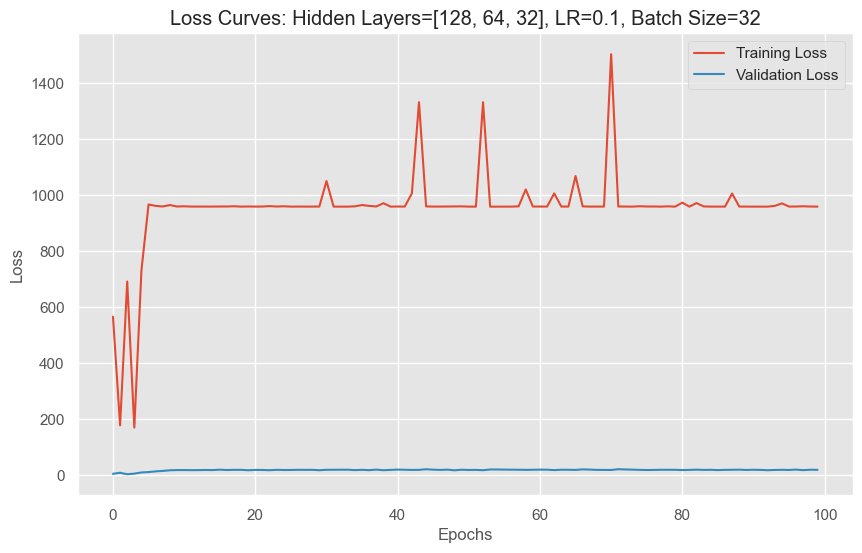

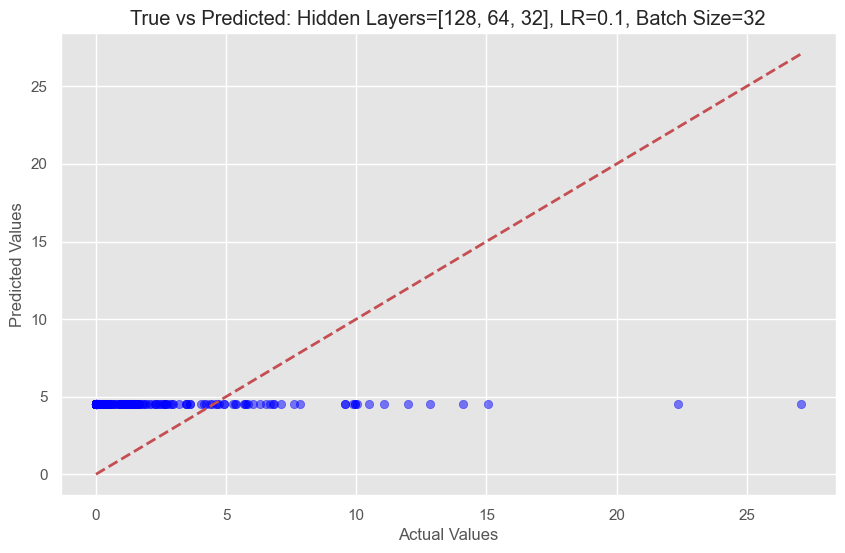


Training with hidden layers [128, 64, 32], learning rate 0.1 and batch size 64...

Epoch 0/100, Training Loss: 982.0059508410367, Validation Loss: 60.900189590454104
Epoch 10/100, Training Loss: 959.7205678766423, Validation Loss: 19.707214736938475
Epoch 20/100, Training Loss: 960.5995233709162, Validation Loss: 19.432482528686524
Epoch 30/100, Training Loss: 966.6300484050404, Validation Loss: 20.38476905822754
Epoch 40/100, Training Loss: 959.0410477031361, Validation Loss: 18.696896934509276
Epoch 50/100, Training Loss: 1006.4578675356778, Validation Loss: 18.731828498840333
Epoch 60/100, Training Loss: 987.1557934500954, Validation Loss: 19.88944435119629
Epoch 70/100, Training Loss: 961.7808439081365, Validation Loss: 17.778107261657716
Epoch 80/100, Training Loss: 1124.5985269546509, Validation Loss: 18.014602279663087
Epoch 90/100, Training Loss: 991.432444485751, Validation Loss: 17.61747798919678
R² Score: -0.6986


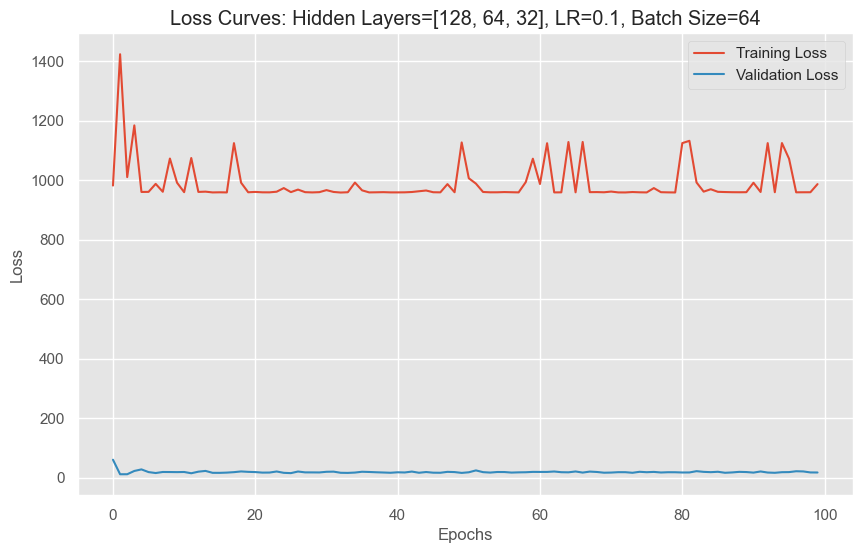

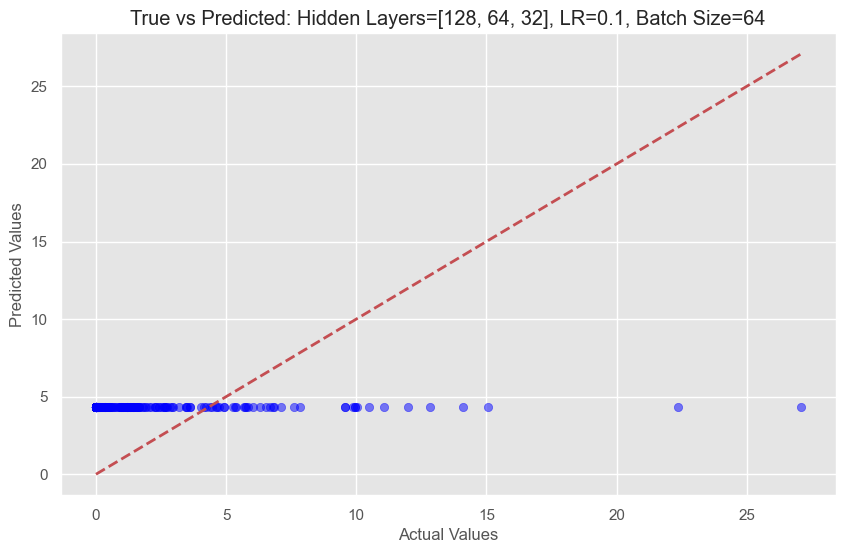


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 8...

Epoch 0/100, Training Loss: 575.0662648995342, Validation Loss: 9.154593430660867
Epoch 10/100, Training Loss: 79.30957601498812, Validation Loss: 1.8940412041706007
Epoch 20/100, Training Loss: 175.97859789253494, Validation Loss: 1.0682682243452684
Epoch 30/100, Training Loss: 9.393299439889487, Validation Loss: 0.8616697516896434
Epoch 40/100, Training Loss: 16.00640245786933, Validation Loss: 5.519063575847729
Epoch 50/100, Training Loss: 5.243794789364518, Validation Loss: 0.7674405839596246
Epoch 60/100, Training Loss: 12.042286269150155, Validation Loss: 0.5423166593788443
Epoch 70/100, Training Loss: 6.1358287116339385, Validation Loss: 0.5901428315083723
Epoch 80/100, Training Loss: 4.92149352665644, Validation Loss: 0.63100501698618
Epoch 90/100, Training Loss: 4.5349335764632235, Validation Loss: 1.2449740338567141
R² Score: 0.9403


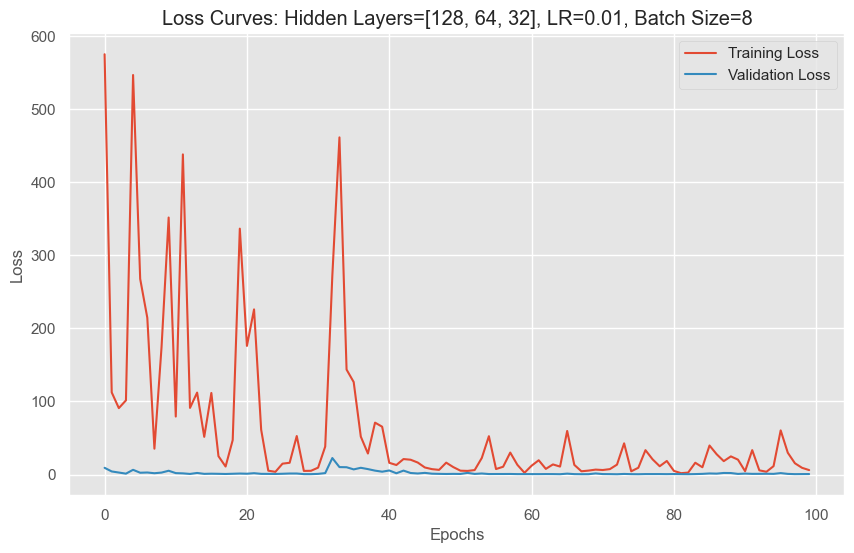

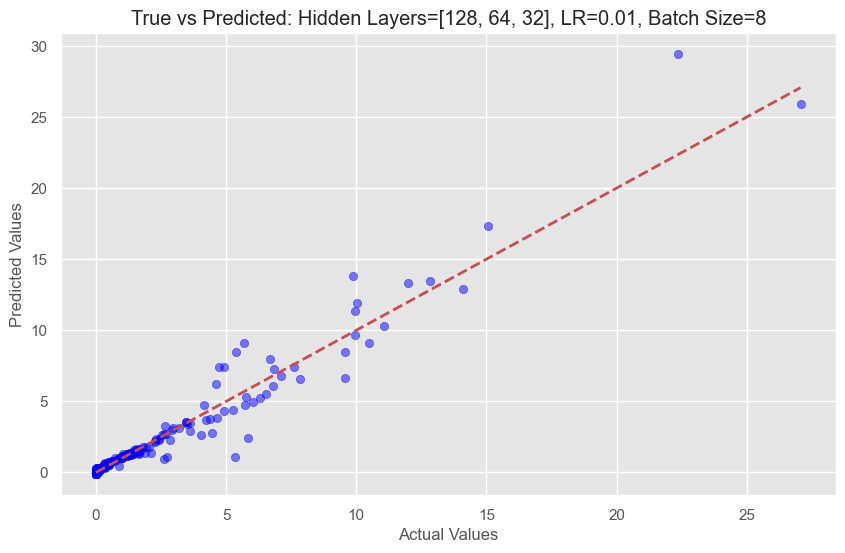


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 16...

Epoch 0/100, Training Loss: 685.2519515129023, Validation Loss: 5.6535771167592
Epoch 10/100, Training Loss: 44.985395211813064, Validation Loss: 3.980617245561198
Epoch 20/100, Training Loss: 71.83985627182695, Validation Loss: 2.8631796115323116
Epoch 30/100, Training Loss: 316.5543867446655, Validation Loss: 2.7842360985906502
Epoch 40/100, Training Loss: 18.071314590614897, Validation Loss: 1.176665302954222
Epoch 50/100, Training Loss: 37.723637043043624, Validation Loss: 2.1182540553180793
Epoch 60/100, Training Loss: 64.78045724990756, Validation Loss: 3.054871678352356
Epoch 70/100, Training Loss: 6.857136624843576, Validation Loss: 0.8695655723935679
Epoch 80/100, Training Loss: 2.572500823542129, Validation Loss: 1.2439213175522654
Epoch 90/100, Training Loss: 4.473760298864786, Validation Loss: 1.0983008071780205
R² Score: 0.9057


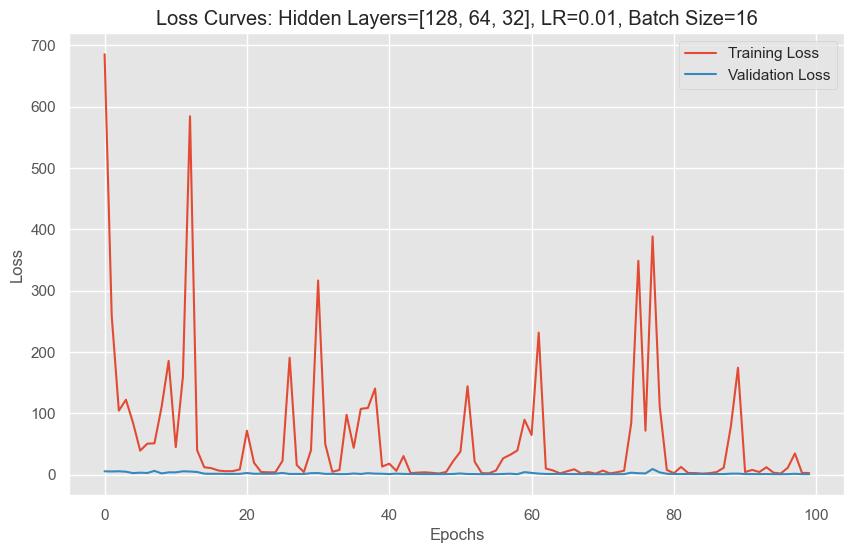

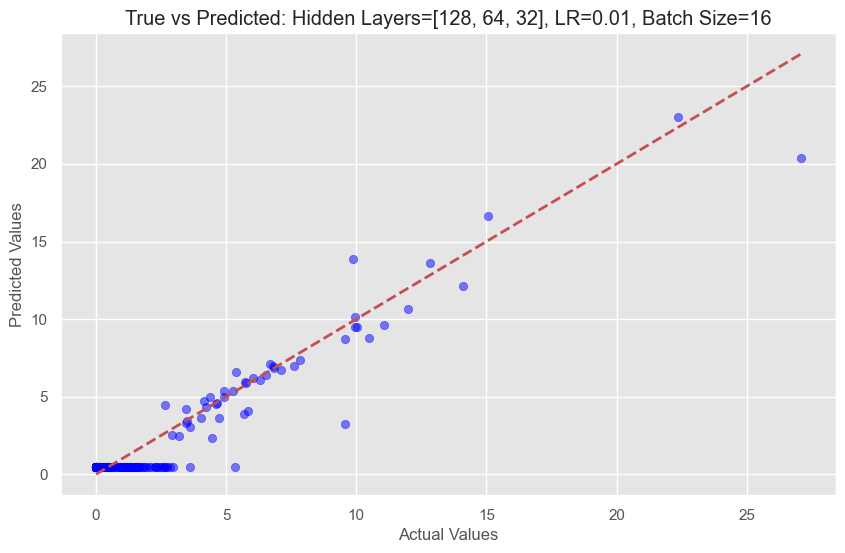


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 32...

Epoch 0/100, Training Loss: 558.5277243744243, Validation Loss: 12.925093394517898
Epoch 10/100, Training Loss: 219.25173686038363, Validation Loss: 1.1111607730388642
Epoch 20/100, Training Loss: 20.424706403504718, Validation Loss: 1.4075072154402732
Epoch 30/100, Training Loss: 10.828554190017961, Validation Loss: 1.6998946234583854
Epoch 40/100, Training Loss: 5.300852808762681, Validation Loss: 1.6267120853066444
Epoch 50/100, Training Loss: 2.3069553781639445, Validation Loss: 1.2158523738384246
Epoch 60/100, Training Loss: 7.371662366119298, Validation Loss: 1.2162466689944267
Epoch 70/100, Training Loss: 4.411742534149777, Validation Loss: 1.0140613332390784
Epoch 80/100, Training Loss: 11.551761203191496, Validation Loss: 1.3894853830337524
Epoch 90/100, Training Loss: 1.6154234558343887, Validation Loss: 0.8965677291154861
R² Score: 0.9102


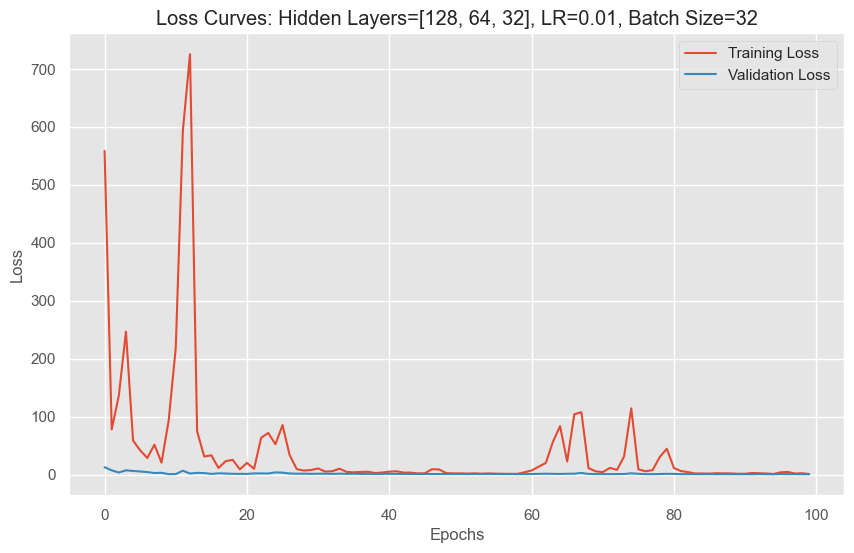

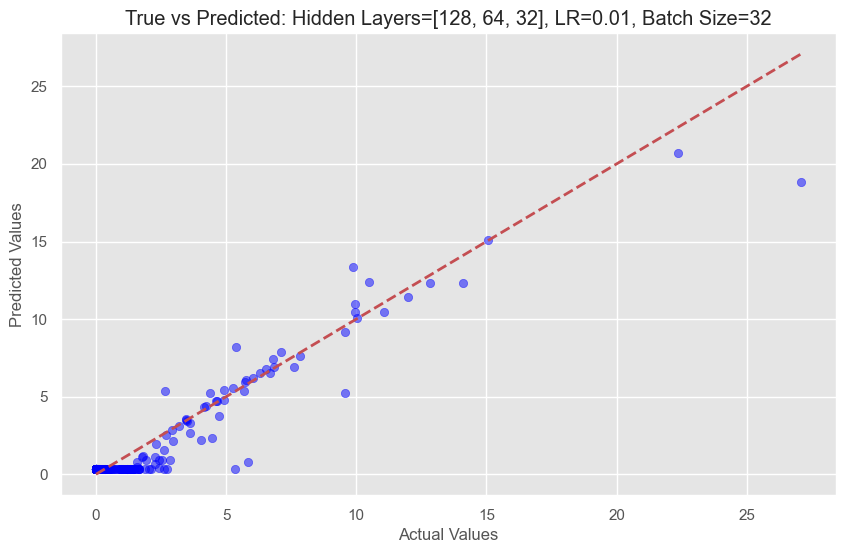


Training with hidden layers [128, 64, 32], learning rate 0.01 and batch size 64...

Epoch 0/100, Training Loss: 940.3954220685092, Validation Loss: 11.518123054504395
Epoch 10/100, Training Loss: 20.238808740269054, Validation Loss: 5.475948476791382
Epoch 20/100, Training Loss: 24.69416674294255, Validation Loss: 0.5835427880287171
Epoch 30/100, Training Loss: 49.5006509477442, Validation Loss: 4.560918521881104
Epoch 40/100, Training Loss: 22.20838817683133, Validation Loss: 5.047320222854614
Epoch 50/100, Training Loss: 7.009728168899363, Validation Loss: 2.1725043058395386
Epoch 60/100, Training Loss: 4.25715586272153, Validation Loss: 1.3832664251327516
Epoch 70/100, Training Loss: 6.880775836381045, Validation Loss: 0.9028750061988831
Epoch 80/100, Training Loss: 2.083746100013906, Validation Loss: 0.6937090158462524
Epoch 90/100, Training Loss: 2.4797790280797263, Validation Loss: 0.6617413282394409
R² Score: 0.9354


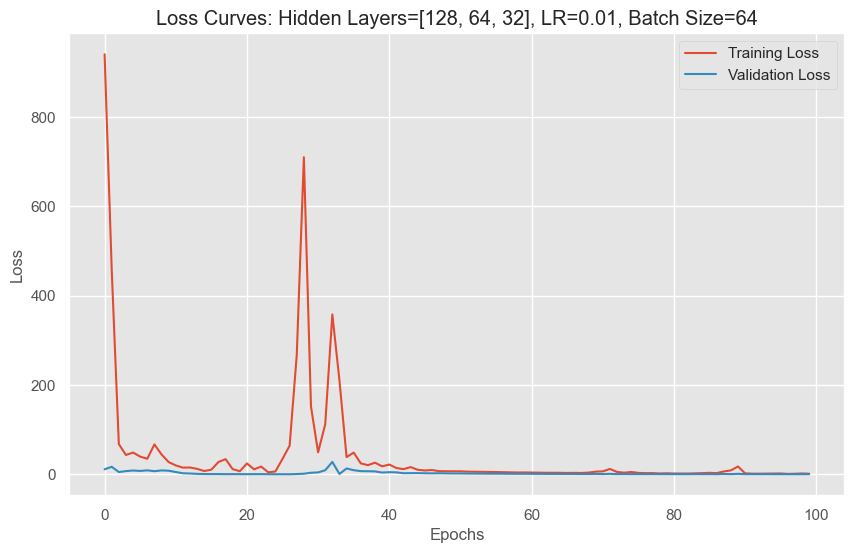

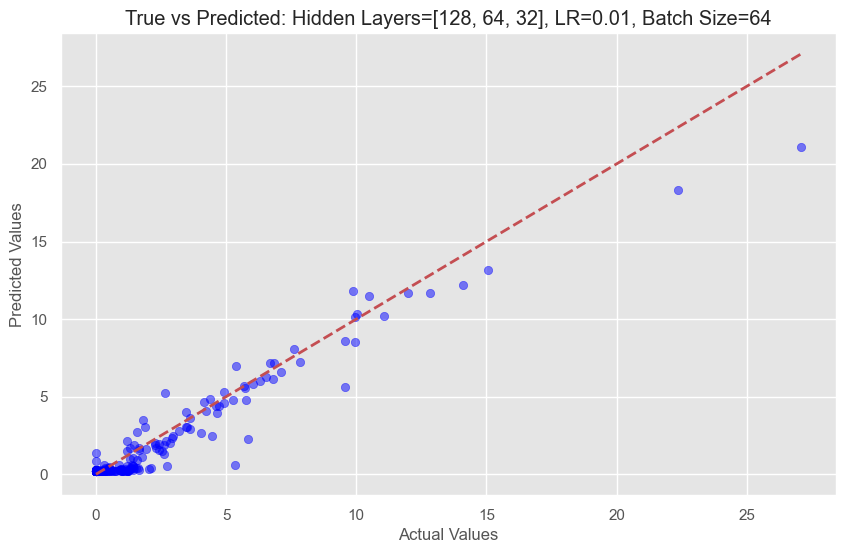


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 8...

Epoch 0/100, Training Loss: 970.8621749013316, Validation Loss: 9.712657400079676
Epoch 10/100, Training Loss: 51.50023067880119, Validation Loss: 1.7065302120471322
Epoch 20/100, Training Loss: 24.189760248095535, Validation Loss: 0.8020229443303637
Epoch 30/100, Training Loss: 18.700402507645098, Validation Loss: 0.5782931174680188
Epoch 40/100, Training Loss: 9.374635305472237, Validation Loss: 1.1926040840712753
Epoch 50/100, Training Loss: 5.685774246317356, Validation Loss: 1.194982299430145
Epoch 60/100, Training Loss: 27.836128099323357, Validation Loss: 1.1526891683807243
Epoch 70/100, Training Loss: 1.9880573574215348, Validation Loss: 0.4891861561635459
Epoch 80/100, Training Loss: 1.7629945999563694, Validation Loss: 0.5658783071699578
Epoch 90/100, Training Loss: 5.394151884087816, Validation Loss: 0.581480261794216
R² Score: 0.9436


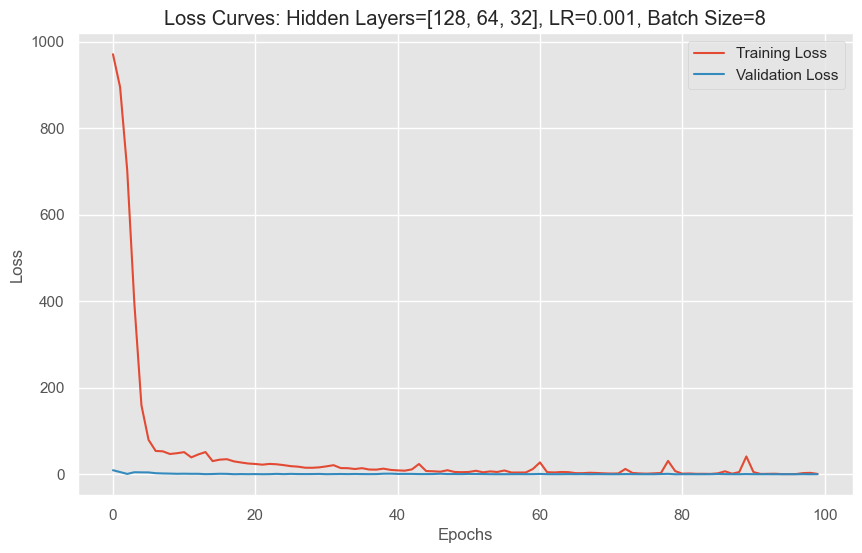

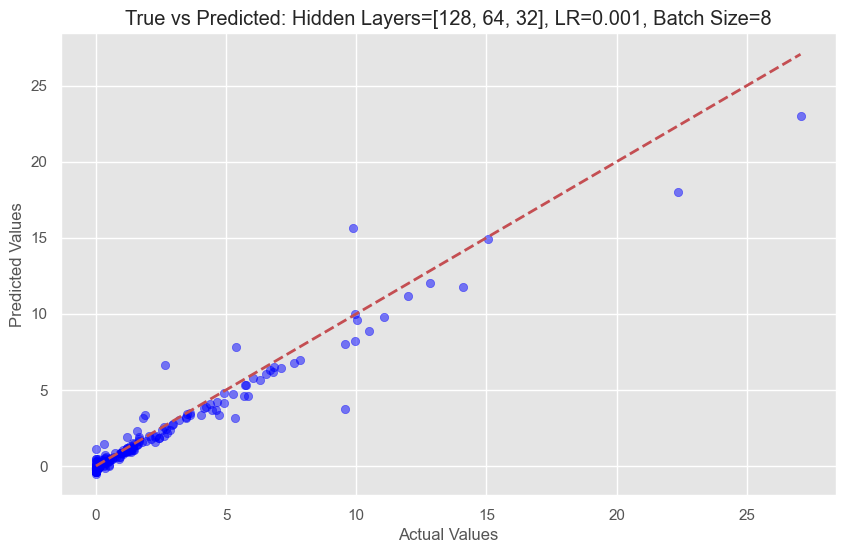


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 16...

Epoch 0/100, Training Loss: 995.5464842832366, Validation Loss: 11.22729820326755
Epoch 10/100, Training Loss: 49.18609114233838, Validation Loss: 3.0007954569239366
Epoch 20/100, Training Loss: 30.53781275273582, Validation Loss: 0.5284106386335272
Epoch 30/100, Training Loss: 15.427318637670819, Validation Loss: 0.5201122590193623
Epoch 40/100, Training Loss: 10.830778917904164, Validation Loss: 0.5331935620817699
Epoch 50/100, Training Loss: 8.026781928400661, Validation Loss: 0.43894802073114797
Epoch 60/100, Training Loss: 4.890733650257421, Validation Loss: 0.4970670467928836
Epoch 70/100, Training Loss: 4.083276866133823, Validation Loss: 0.5201629827681341
Epoch 80/100, Training Loss: 2.5029041378130747, Validation Loss: 0.34594772040451827
Epoch 90/100, Training Loss: 2.0025536824277665, Validation Loss: 0.4191240982005471
R² Score: 0.9409


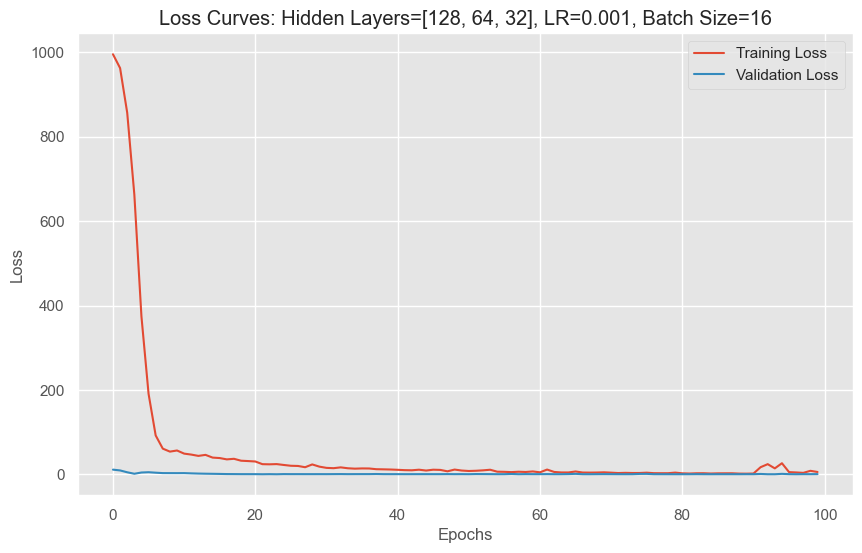

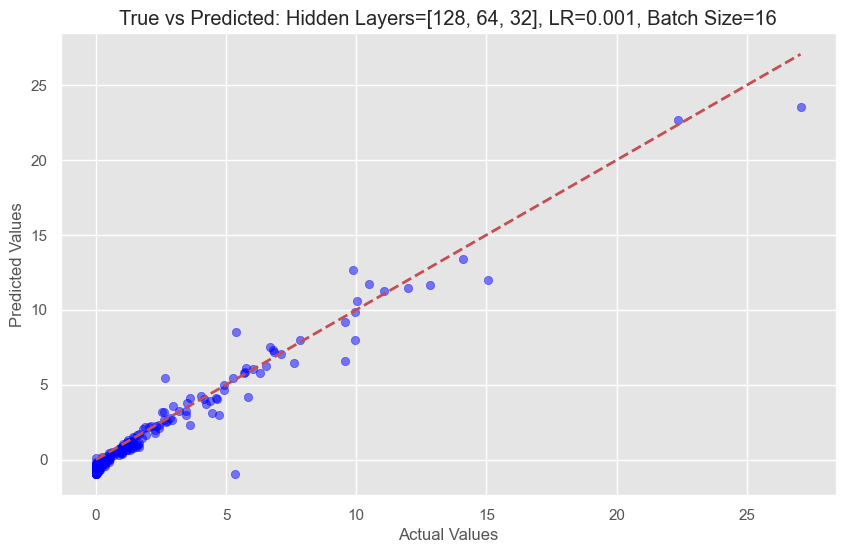


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 32...

Epoch 0/100, Training Loss: 972.3371906280518, Validation Loss: 11.029502737522126
Epoch 10/100, Training Loss: 59.10711318254471, Validation Loss: 3.3195124864578247
Epoch 20/100, Training Loss: 33.837698508392684, Validation Loss: 1.7785038486123086
Epoch 30/100, Training Loss: 22.94468184492805, Validation Loss: 1.5059327490627765
Epoch 40/100, Training Loss: 14.353832585567778, Validation Loss: 1.342489518970251
Epoch 50/100, Training Loss: 9.242426222867586, Validation Loss: 1.4014229618012906
Epoch 60/100, Training Loss: 7.100484245541421, Validation Loss: 1.3115245897322894
Epoch 70/100, Training Loss: 5.8014162921092725, Validation Loss: 1.2155119258910418
Epoch 80/100, Training Loss: 26.479924646290865, Validation Loss: 1.7280367985367775
Epoch 90/100, Training Loss: 2.755993867123669, Validation Loss: 0.9153988709207624
R² Score: 0.9197


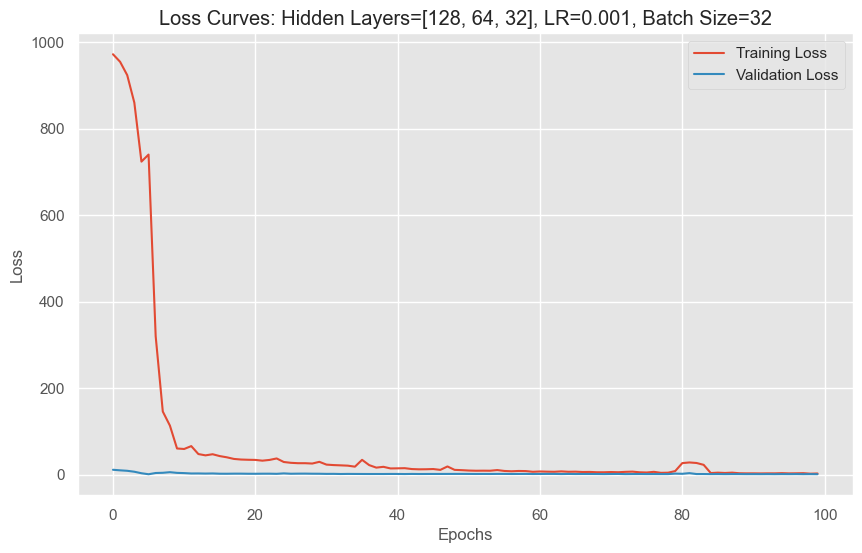

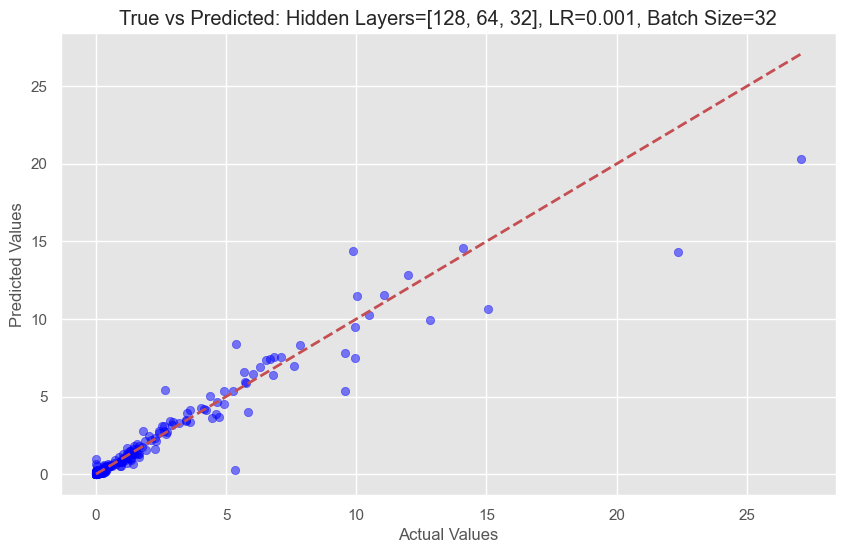


Training with hidden layers [128, 64, 32], learning rate 0.001 and batch size 64...

Epoch 0/100, Training Loss: 975.2722242095253, Validation Loss: 12.54763822555542
Epoch 10/100, Training Loss: 188.040057962591, Validation Loss: 9.640109539031982
Epoch 20/100, Training Loss: 43.15203566984697, Validation Loss: 3.9755482912063598
Epoch 30/100, Training Loss: 36.37897755882957, Validation Loss: 2.416722321510315
Epoch 40/100, Training Loss: 23.639445172114804, Validation Loss: 0.7408017992973328
Epoch 50/100, Training Loss: 16.426658635789696, Validation Loss: 0.6739586234092713
Epoch 60/100, Training Loss: 12.017422399737619, Validation Loss: 0.9452092170715332
Epoch 70/100, Training Loss: 8.94424625418403, Validation Loss: 0.7918001174926758
Epoch 80/100, Training Loss: 7.1081534271890465, Validation Loss: 0.6995314836502076
Epoch 90/100, Training Loss: 5.978409127078273, Validation Loss: 0.6537782669067382
R² Score: 0.9475


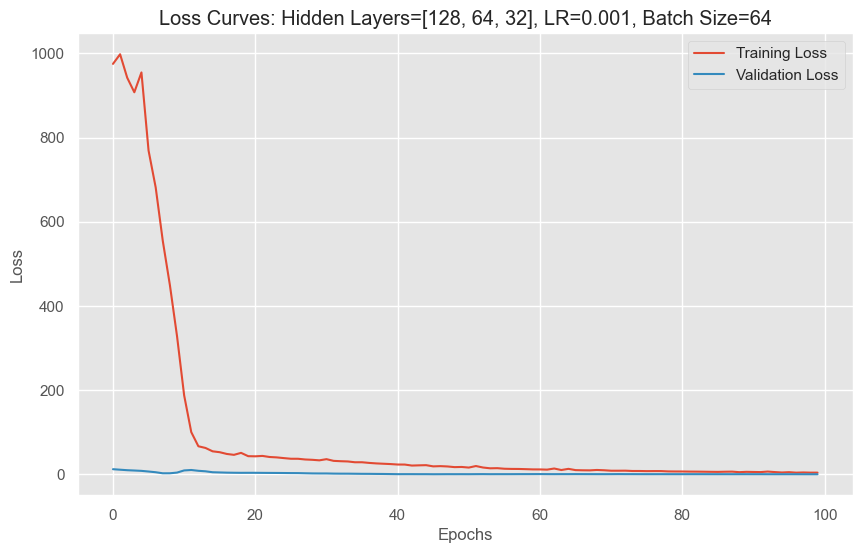

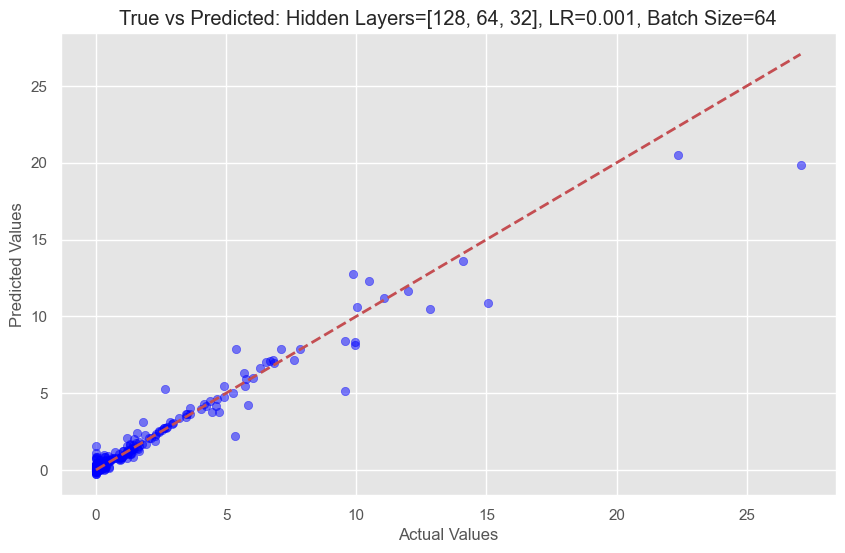


Best Model Configuration:
  Hidden Layers: [128, 64]
  Learning Rate: 0.01
  Batch Size: 32
  Best R² Score: 0.9666


In [18]:
# Set hyperparameters (list of architectures, learning rates, and batch sizes to test)
hidden_layers_list = [
    [64],         # 1 hidden layer
    [128, 64],    # 2 hidden layers
    [128, 64, 32]  # 3 hidden layers (best candidate from earlier)
]
learning_rates = [0.1, 0.01, 0.001]  # Learning rates to try
batch_sizes = [8, 16, 32, 64]  # Batch sizes to try
epochs = 100  # Number of epochs

# Run the experiment
run_optimized_experiment(hidden_layers_list, learning_rates, batch_sizes, epochs)
